### Load all

In [2]:
import os
os.chdir(os.path.abspath('..')) 

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# My codes
import decoder_PC2d
import model_viz_functions_riab as modelviz_utils
import model_viz_loaders as modelviz_loaders

############################################################

import einops
import os

import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn

jax.config.parse_flags_with_absl()
jax.config.update("jax_numpy_rank_promotion", "raise")

import matplotlib.pyplot as plt
import joblib
# import pathlib
import pickle


import ratinabox
from ratinabox.Neurons import PlaceCells
# from ratinabox.Agent import Agent

from dsm import datasets, envs, stade #, #train #metrics, console
# from dsm import plotting, rewards 
# from dsm.state import State
# from dsm.plotting import utils as plot_utils #fig_to_ndarray

import copy
from matplotlib import colors
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib import gridspec

import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap_ratemap = 'inferno'  

[13:36:31] INFO     MUJOCO_GL is not set, so an OpenGL backend will be chosen automatically.         ]8;id=302575;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=21189;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#88\88]8;;\

           INFO     Successfully imported OpenGL backend: glfw                                       ]8;id=772754;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=42524;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#96\96]8;;\

           INFO     MuJoCo library version is: 2.3.7                                                 ]8;id=681008;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py\__init__.py]8;;\:]8;id=606675;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py#31\31]8;;\

/home/sruthi/Sruthi/dsm-hippocampus-main/dsm/stade.py:150: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  seed: int | jax.random.KeyArray | npr.SeedSequence | None,
/home/sruthi/Sruthi/dsm-hippocampus-main/dsm/stade.py:227: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  seed: int | jax.random.KeyArray | npr.SeedSequence | None = None,
/home/sruthi/Sruthi/dsm-hippocampus-main/dsm/train.py:119: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Arr

### ENV and MODEL path and CONFIGs here

In [4]:
ENVIRONMENT = "Ratinabox-v0-pc-random"
model_path = "logdir-rat_50pc_random_walk"

In [5]:
num_samples= 10 #config.plot_num_samples # Number of samples the model should generate

### Env and dataset

In [6]:
folder_dataset_path = os.path.dirname(datasets._DATASET_REGISTRY[ENVIRONMENT])
dataset = datasets.make_dataset(ENVIRONMENT)
# folder_dataset_path = "/media/sruthi/SSD2/sruthi_data/ratinaboxPCgoal/sac/"
# env_data_path = pathlib.Path(folder_dataset_path+"dataset.pkl")
# with env_data_path.open("rb") as fp:
#         dataset = pickle.load(fp)
# print(folder_dataset_path)
print("Dataset observations shape: ",dataset.observation.shape)
pc_path = folder_dataset_path+'/placecells_params.pkl'
log_file = folder_dataset_path+'/my_log.log'

env = envs.make(ENVIRONMENT)  #config.env
Ag = env.agent_lookup('agent_0')[0] # Agent(env) will create a new agent - agent0 already added in envs.py

PC_params = joblib.load(pc_path)
NUM_STATE_DIM_CELLS = PC_params['n']
print('NUM_STATE_DIM_CELLS:',NUM_STATE_DIM_CELLS)
PCs = PlaceCells(Ag, params=PC_params) 
orig_pc_centres = PCs.place_cell_centres.copy()

# Ag1 = Agent(env) #will create a new agent - agent0 already added in envs.py
# env.add_agents(Ag1)
# PCs_changed = PlaceCells(Ag1, params=PC_params.copy()) 

# fig, ax = PCs.plot_rate_map(chosen_neurons="all")
env = stade.GymEnvWrapper(env, with_infos=False, seed=None)
# data = datasets.make_dataset(config.env)

Dataset observations shape:  (24000, 50)
NUM_STATE_DIM_CELLS: 50


In [7]:
# PCs2 = copy.deepcopy(PCs)


In [8]:
# plt.figure(figsize=(5, 5))
# plt.scatter(PCs.place_cell_centres[:,0], PCs.place_cell_centres[:,1], c='r', s=10)

### Input xs - create dataset of place cell activations over the whole env

In [9]:
# source states to feed to the model
env_coords_small = Ag.Environment.discretise_environment(dx=0.1) # dx=Ag.environment.scale/10 , dx=0.01
# dx=0.05 , (400, 2)
#dx = 0.2, (25,2)
env_coords_small = env_coords_small.reshape(-1, env_coords_small.shape[-1])
# pc_full_env = PCs.get_state(evaluate_at="all").T # N of 10000 values corresponding to ag.Environment.flattened_discrete_coords # len 10000
source_states_env = PCs.get_state(evaluate_at=None, pos=env_coords_small).T
print(source_states_env.shape)
# plt.plot(env_coords_small[:,0],env_coords_small[:,1],'o')
# plt.ylim(0, 1)
# plt.xlim(0, 1)

unique_xpos, indices = np.unique(env_coords_small[:, 0], return_index=True)
xpos = unique_xpos[np.argsort(indices)]
unique_ypos, indices = np.unique(env_coords_small[:, 1], return_index=True)
ypos = unique_ypos[np.argsort(indices)]

# positions_all = decoder_PC2d.decode_position(PCs,source_states_env,plot=True)
# source_states_env_PCactivities = decoder_PC2d.simple_decode_position(source_states_env, env_coords, pc_full_env,plot=False)

(100, 50)


/tmp/ipykernel_144384/1624334184.py:11: UserWarning: The following kwargs were not used by contour: 'leys'
  cbar_vals = ax.contourf(xpos, ypos, source_states_curr, cmap=cmap_ratemap, leys=20)


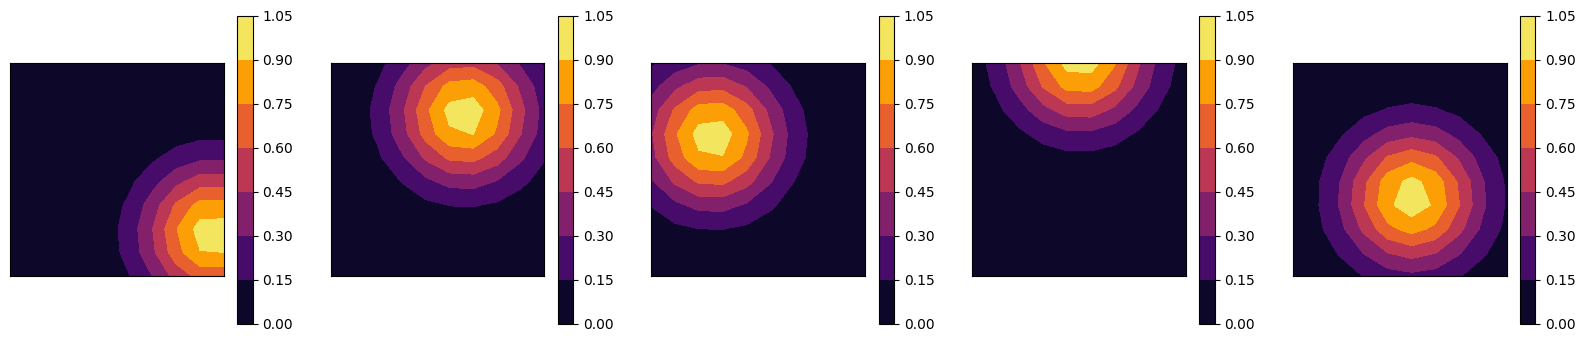

In [10]:
# Viz random PCs
source_states_all = PCs.get_state(evaluate_at=None, pos=env_coords_small).T 

np.random.seed(42)
neuron_indices = np.random.choice(source_states_all.shape[1], size=5, replace=False)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, neuron_idx in zip(axes, neuron_indices):
    source_states_curr = source_states_all[:, neuron_idx].reshape(len(ypos), len(xpos))
    # cbar_vals = ax.imshow(source_states_curr, cmap=cmap_ratemap)
    cbar_vals = ax.contourf(xpos, ypos, source_states_curr, cmap=cmap_ratemap, leys=20)
    ax.set_aspect('equal')
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.yaxis.set_major_locator(ticker.NullLocator())
    fig.colorbar(cbar_vals, ax=ax)

plt.show()

### Decode position from PC activity

positions_std [[0.01347883 0.02687087]
 [0.0081113  0.01453873]
 [0.01981014 0.01626942]
 ...
 [0.03814974 0.01616291]
 [0.03457743 0.01333308]
 [0.02695779 0.010373  ]]


/home/sruthi/Sruthi/dsm-hippocampus-main/decoder_PC2d.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


([], [])

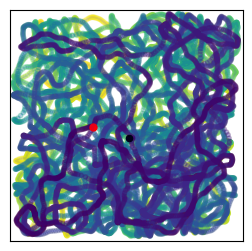

In [11]:
decoder_PC2d.train_xy_Net(PCs, Ag,epochs=100)
positions_all = decoder_PC2d.decode_position(PCs,dataset.observation,plot=True,method='dropoutNet')
positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,dataset.observation, method='dropoutNet',return_std=True)
print('positions_std',positions_std)

plt.yticks([])
plt.xticks([])
# dataset_positions = decoder_PC2d.simple_decode_position(dataset.observation,env_coords,pc_full_env,plot=True)
# # WORKS only when dx=0.01 in Ag.Environment.discretise_environment(dx=0.01) ?
# print(dataset_positions.shape)
# decoder_PC2d.train_decoder(PCs,env_coords=env_coords, method='GP') # GP  # method='LR'
# positions_all = decoder_PC2d.decode_position(PCs,dataset.observation,plot=True,method='GP') 
# positions_pred, positions_std = decoder_PC2d.decode_position(PCs,dataset.observation, method='GP',return_std=True)
# print('positions_std',positions_std)

### Model stuff - restoring checkpoint

In [12]:
state, config = modelviz_loaders.load_model_state_and_config_from_checkpoint_dir(model_path, env)

print('Saved model state: Generator params shapes:',jax.tree_map(jnp.shape, state.generator.params))
# num_state_dims is the expected number of input place cells
print(state.generator.apply_fn)  # MLP (num_layers = 3, num_hidden_units = 32, num_atoms = 11, num_state_dims = 50)
# print(state.generator.params['params']['model'].keys())   #  dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3'])
# print(state.generator.params['params']['model']['Dense_3']['bias'].shape)  #n_outer, 

[13:37:01] WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=515655;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=181841;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

           INFO     Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered     ]8;id=479758;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=480927;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    platform with name: "rocm". Available platform names are: CUDA                                 

           INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so:       ]8;id=976915;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=738381;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    libtpu.so: cannot open shared object file: No such file or directory                           

deleted  workdir
debug latest_step 500000


[13:37:04] INFO     Restoring item from                                                         ]8;id=549425;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=771552;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/500000                    
                    .                                                                                              

/home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1464: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


           INFO     Finished restoring checkpoint from                                          ]8;id=48375;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=717082;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/500000                    
                    .                                                                                              

Saved model state: Generator params shapes: {'params': {'model': {'Dense_0': {'bias': (10, 32), 'kernel': (10, 55, 32)}, 'Dense_1': {'bias': (10, 32), 'kernel': (10, 32, 32)}, 'Dense_2': {'bias': (10, 32), 'kernel': (10, 32, 32)}, 'Dense_3': {'bias': (10, 50), 'kernel': (10, 32, 50)}}}}
<bound method Module.apply of DistributionalSRGenerator(
    # attributes
    model = MLP(
        # attributes
        num_layers = 3
        num_hidden_units = 32
        num_outputs = None
        module = Dense
        activation = leaky_relu
        dtype = float32
        param_dtype = float32
    )
    num_atoms = 10
    num_state_dims = 50
)>


### compute DSM samples

atom_input = latent+source_state

DSM model input (n_samples, n_atoms, atom_input)

In [13]:
is_close = np.isclose(env_coords_small, [0.3,0.4], atol=1e-1)
sel_val_indices = np.where(np.all(is_close, axis=1))[0]
sel_val_indices

array([52, 53, 62, 63])

source pos:  [0.25 0.35]
Max SD of samples decoded with dropoutNet: (0.15208907, 0.100135945) ; Atom 4
decoded source:  [0.25254446 0.35724953]


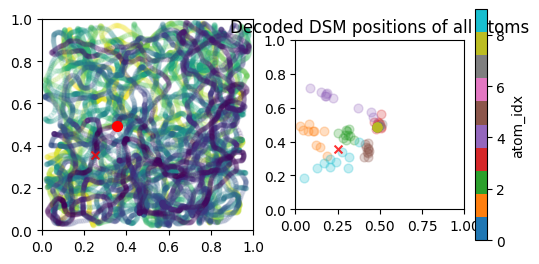

In [14]:
source_idx = 62
source=source_states_env[source_idx]
print('source pos: ',env_coords_small[source_idx])
source, samples = modelviz_loaders.compute_DSM_samples_single_source(
        state.generator, jax.random.PRNGKey(0), config=config, source_state_current=source, num_samples = num_samples )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=True,atom='all',method='dropoutNet')
# modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='GP')

# atom_idx = 2
# positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[atom_idx], method='dropoutNet',return_std=True)
# print(f'SD of decoded samples with dropoutNet:{positions_std}')
# # plot of positions_pred
# modelviz_utils.plot_samples(PCs, dataset.observation, samples,source, make_dataset=False,atom=atom_idx,method='dropoutNet')

original source:  [0.55 0.25]
Max SD of samples decoded with dropoutNet: (0.24514236, 0.26880994) ; Atom 9
decoded source:  [0.5444916  0.23754036]


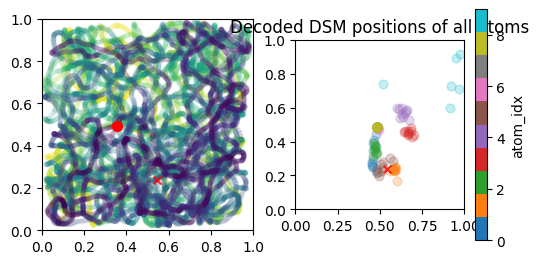

original source:  [0.55 0.25]
Max SD of samples decoded with dropoutNet: (0.20847665, 0.25712875) ; Atom 9
decoded source:  [0.5444916  0.23754036]


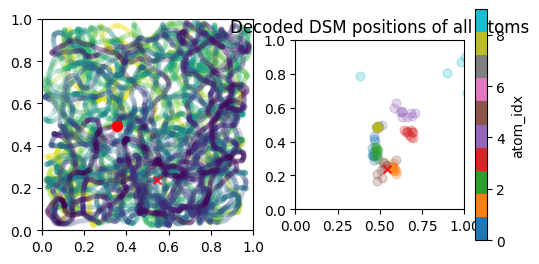

In [15]:
source_idx = 75
source=source_states_env[source_idx]
print('original source: ',env_coords_small[source_idx])
latent_rng = jax.random.PRNGKey(0)
source, samples = modelviz_loaders.compute_DSM_samples_single_source(
        state.generator, latent_rng, config=config, source_state_current=source, num_samples = num_samples
    )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=True,atom='all',method='dropoutNet')
# modelviz_utils.plot_samples(samples,source, make_dataset=True,atom='all',LR=True)

source_idx = 75
source=source_states_env[source_idx]
print('original source: ',env_coords_small[source_idx])
latent_rng = jax.random.PRNGKey(2)
source, samples = modelviz_loaders.compute_DSM_samples_single_source(
        state.generator, latent_rng, config=config, source_state_current=source, num_samples = num_samples
    )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=True,atom='all',method='dropoutNet')
# modelviz_utils.plot_samples(samples,source, make_dataset=True,atom='all',LR=True)

original source:  [0.55 0.25]
Using provided zs
Max SD of samples decoded with dropoutNet: (0.24863318, 0.1979441) ; Atom 9
decoded source:  [0.5444916  0.23754036]


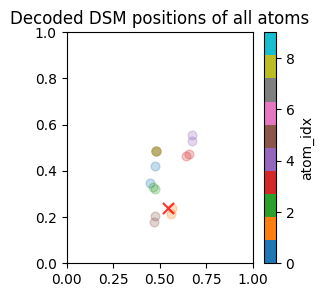

In [16]:
num_samples= 2
source_idx = 75
source=source_states_env[source_idx]
print('original source: ',env_coords_small[source_idx])
latent_rng = jax.random.PRNGKey(10)
z0 = np.ones((num_samples, config.num_outer, config.latent_dims)) #*10  # latent_rng not used if zs provided
source, samples = modelviz_loaders.compute_DSM_samples_single_source(
        state.generator, latent_rng,zs=z0, config=config, source_state_current=source, num_samples = num_samples
    )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='dropoutNet')
# modelviz_utils.plot_samples(samples,source, make_dataset=True,atom='all',LR=True)

### Predicting multiple samples

In [17]:
import importlib 
importlib.reload(modelviz_utils)

<module 'model_viz_functions_riab' from '/home/sruthi/Sruthi/dsm-hippocampus-main/model_viz_functions_riab.py'>

In [18]:
env_coords_small = Ag.Environment.discretise_environment(dx=0.1) # dx=Ag.environment.scale/10 , dx=0.01
# dx=0.05 , (400, 2)
#dx = 0.2, (25,2)
env_coords_small = env_coords_small.reshape(-1, env_coords_small.shape[-1])
# pc_full_env = PCs.get_state(evaluate_at="all").T # N of 10000 values corresponding to ag.Environment.flattened_discrete_coords # len 10000
sources_all_small = PCs.get_state(evaluate_at=None, pos=env_coords_small).T
latent_rng_seed = 0

/tmp/ipykernel_144384/575706274.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reversed_map = plt.cm.get_cmap('viridis') .reversed()


Text(0.5, 0.98, 'Source states')

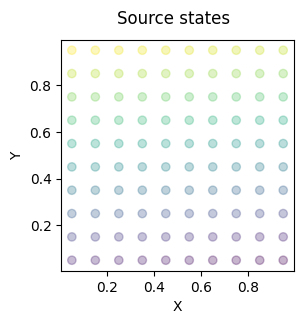

In [19]:
# All atoms - For the same source state - Two different latents (potentially unlimited number of latents) 
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
colors = range(len(env_coords_small))  # Create a list of numbers from 0 to len(xs)-1
reversed_map = plt.cm.get_cmap('viridis') .reversed() 
scatter = axs.scatter(env_coords_small[:,0], env_coords_small[:,1], alpha=0.3, c=colors, cmap=reversed_map)  # Use the numbers as colors
axs.set_xlabel('X') 
axs.set_ylabel('Y')
fig.suptitle('Source states')

Processing atoms: 100%|██████████| 10/10 [01:53<00:00, 11.40s/it]
/home/sruthi/Sruthi/dsm-hippocampus-main/model_viz_functions_riab.py:494: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


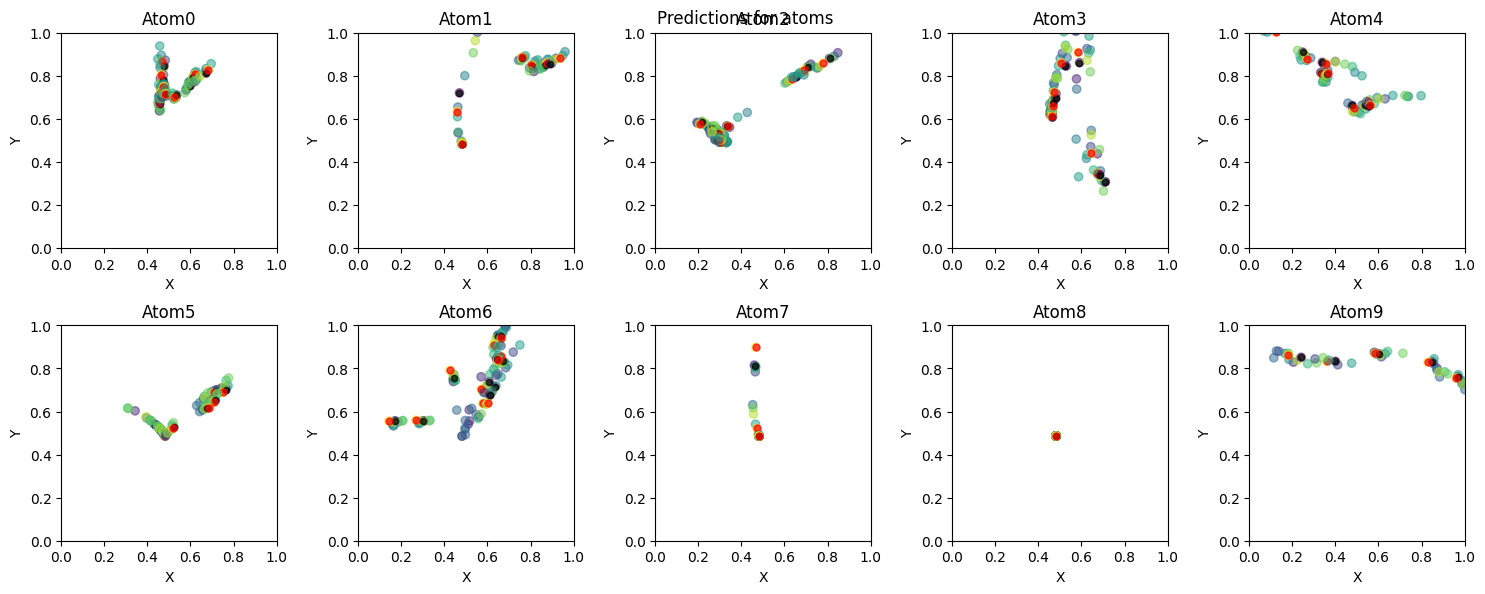

In [20]:
preds1 = modelviz_utils.get_multiple_predictions_atoms(config, latent_rng_seed, state.generator, sources_all_small, 
                                            PCs, atoms_sel='all', num_samples=10, title='Predictions for atoms')
modelviz_utils.plot_multiple_predictions_atoms(preds1, num_samples=10, title='Predictions for atoms')

### Avg atoms

In [21]:
layers = ['Dense_3',]
latent_rng_seed = 0 
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 
sources_all_small = PCs.get_state(evaluate_at=None, pos=env_coords_small).T

activations_layer_all_atoms = [] # of length num_ckpts
for atom_num in range(config.num_outer):
    atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, sources_all_small,zs, layers)
    # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
    activations_layer_all_atoms.append(activations_layer) 

### ALL SOURCES _ PREDICTIONs

/home/sruthi/Sruthi/dsm-hippocampus-main/decoder_PC2d.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')
Processing atoms: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]
/home/sruthi/Sruthi/dsm-hippocampus-main/model_viz_functions_riab.py:416: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


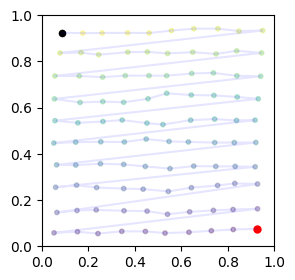

<Figure size 640x480 with 0 Axes>

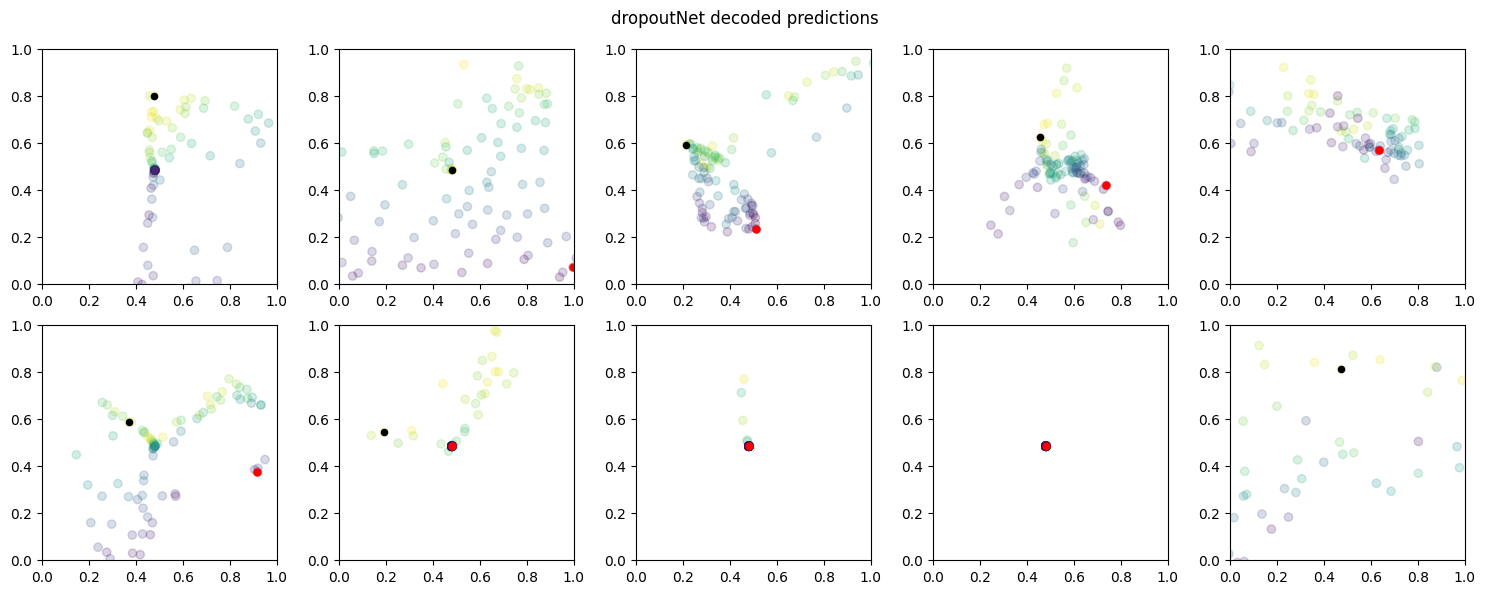

In [22]:
# OLD
env_coords_point05 = Ag.Environment.discretise_environment(dx=0.1) # dx=Ag.environment.scale/10 , dx=0.01
# dx=0.05 , (400, 2)
#dx = 0.2, (25,2)
env_coords_point05 = env_coords_point05.reshape(-1, env_coords_point05.shape[-1])
# pc_full_env = PCs.get_state(evaluate_at="all").T # N of 10000 values corresponding to ag.Environment.flattened_discrete_coords # len 10000
source_PCs = PCs.get_state(evaluate_at=None, pos=env_coords_point05).T

# source_PCs = source_states_env #[::2]
latent_rng_seed = 0
positions_source  = decoder_PC2d.decode_position(PCs, source_PCs , plot=True, method='dropoutNet')
modelviz_utils.plot_predictions_atoms(config, latent_rng_seed, state.generator, source_PCs, 
                              PCs, method='dropoutNet', title='dropoutNet decoded predictions')

# atom_idx = [8]
# modelviz_utils.plot_predictions_atoms(config, latent_rng_seed, state.generator, source_states, 
#                               PCs, atoms_sel=atom_idx, method='dropoutNet')

In [23]:
# # OLD
# env_coords_point05 = Ag.Environment.discretise_environment(dx=0.1) # dx=Ag.environment.scale/10 , dx=0.01
# # dx=0.05 , (400, 2)
# #dx = 0.2, (25,2)
# env_coords_point05 = env_coords_point05.reshape(-1, env_coords_point05.shape[-1])
# # pc_full_env = PCs.get_state(evaluate_at="all").T # N of 10000 values corresponding to ag.Environment.flattened_discrete_coords # len 10000
# source_PCs = PCs.get_state(evaluate_at=None, pos=env_coords_point05).T

# # source_PCs = source_states_env #[::2]
# latent_rng_seed = 0
# positions_source  = decoder_PC2d.decode_position(PCs, source_PCs , plot=True, method='dropoutNet')
# modelviz_utils.plot_predictions_atoms(config, latent_rng_seed, state.generator, source_PCs, 
#                               PCs, method='dropoutNet', title='dropoutNet decoded predictions')

# # atom_idx = [8]
# # modelviz_utils.plot_predictions_atoms(config, latent_rng_seed, state.generator, source_states, 
# #                               PCs, atoms_sel=atom_idx, method='dropoutNet')

In [24]:
len(ypos), len(xpos)

(10, 10)

### Predicted X and Y - all atoms - rate map

In [ ]:
env_coords_small = Ag.Environment.discretise_environment(dx=0.1) # dx=Ag.environment.scale/10 , dx=0.01
env_coords_small = env_coords_small.reshape(-1, env_coords_small.shape[-1])
source_states_env = PCs.get_state(evaluate_at=None, pos=env_coords_small).T

unique_xpos, indices = np.unique(env_coords_small[:, 0], return_index=True)
xpos = unique_xpos[np.argsort(indices)]
unique_ypos, indices = np.unique(env_coords_small[:, 1], return_index=True)
ypos = unique_ypos[np.argsort(indices)]

In [ ]:
# All atoms - Plot rate map of neuron_idx
layers = ['Dense_3',]
latent_rng_seed = 0 
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

activations_layer_all_atoms = [] # of length num_ckpts
for atom_num in range(config.num_outer):
    atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_env,zs, layers)
    # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
    activations_layer_all_atoms.append(activations_layer)


In [ ]:
# Plot with respect to X and Y 
# # single sample prediction from each atom in a subplot 

import matplotlib.colors as mcolors

def plot_atom_activations_wrt_chosen_source_dim(activations_layer_all_atoms,xpos,ypos , srcdim='X'):
    
    n = len(activations_layer_all_atoms) # 10
    cols = 5 
    rows = n // cols 
    position = range(1,n + 1)
    fig = plt.figure(figsize=(10,4))

    # Find global min and max
    global_min = 0
    global_max = 1
    norm = mcolors.Normalize(vmin=global_min, vmax=global_max)

    # scatters = []
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    for k, activations_layer in enumerate(activations_layer_all_atoms): 
        ax = fig.add_subplot(rows, cols, position[k])
        label = f'Atom: {k}'
        assert activations_layer.shape == source_states_env.shape
        positions_pred  = decoder_PC2d.decode_position(PCs, activations_layer)
        if srcdim == 'X':
            chosen_pred = positions_pred[:, 0]
        elif srcdim == 'Y':
            chosen_pred =  positions_pred[:, 1]
        activations_2d = chosen_pred.reshape(len(ypos), len(xpos))

        # scatter = ax.imshow(activations_2d, cmap='inferno', vmin=global_min, vmax=global_max, aspect='auto')
        # ax.set_aspect('equal')
        scatter = ax.contourf(xpos, ypos, activations_2d, 
                            cmap='inferno', levels=20, norm=norm) # vmin=global_min, vmax=global_max
        ax.set_box_aspect(1)

        # scatters.append(scatter)
        if n==config.num_outer:
            ax.set_title(f'Atom{k}')
        plt.xticks([]), plt.yticks([]) 
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
    sm.set_array([])  # This is required to create the colorbar
    fig.colorbar(sm, ax=fig.get_axes(), label=srcdim)
    # fig.suptitle('Thetadot predictions')
    plt.show()

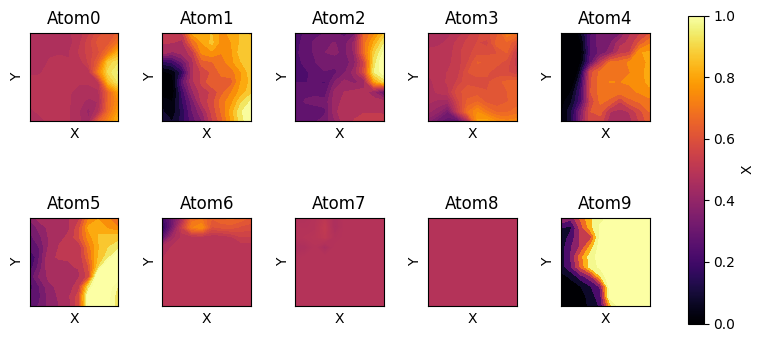

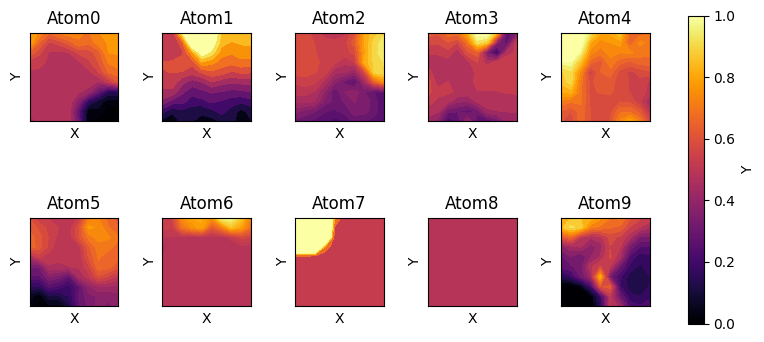

In [ ]:
plot_atom_activations_wrt_chosen_source_dim(activations_layer_all_atoms, xpos, ypos, srcdim='X')
plot_atom_activations_wrt_chosen_source_dim(activations_layer_all_atoms, xpos, ypos, srcdim='Y')

In [26]:
np.random.seed(42)
neuron_indices = np.random.choice(source_states_all.shape[1], size=5, replace=False)
neuron_indices

array([13, 39, 30, 45, 17])

NEURON:  13


/home/sruthi/Sruthi/dsm-hippocampus-main/model_viz_functions_riab.py:249: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.2, hspace=0.2)


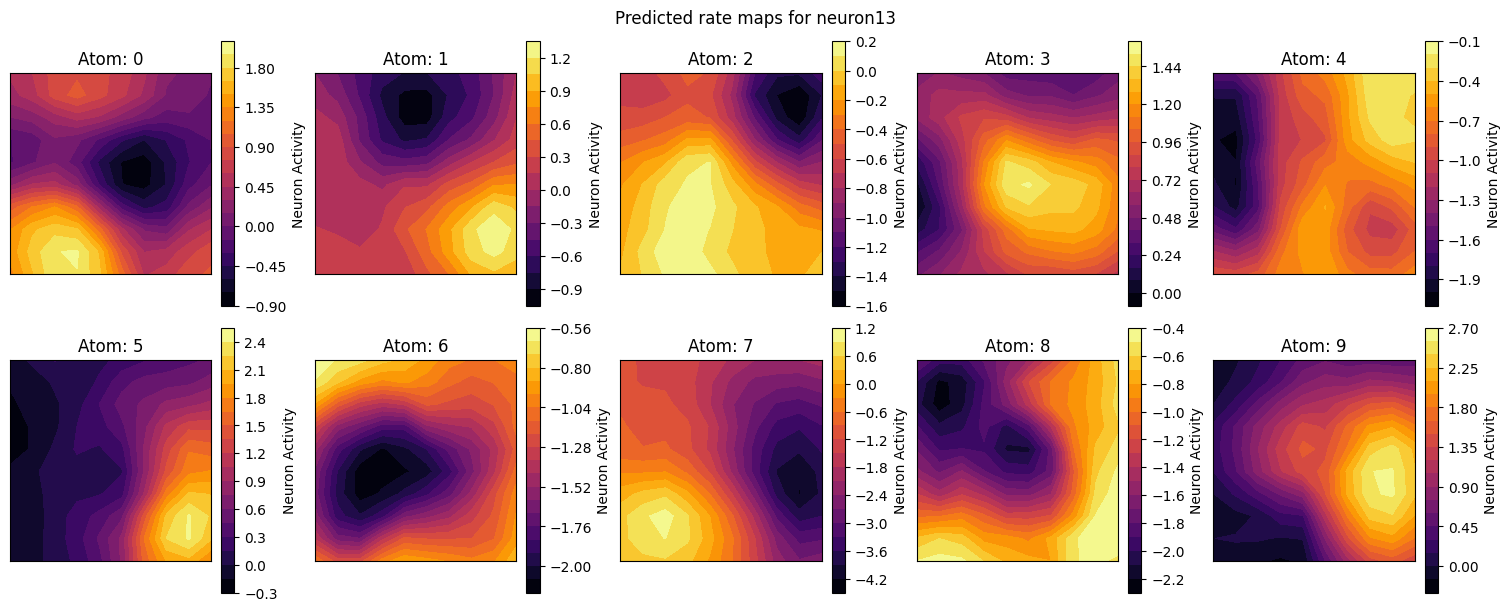

    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again


(<Figure size 250x250 with 2 Axes>, array([<Axes: >], dtype=object))

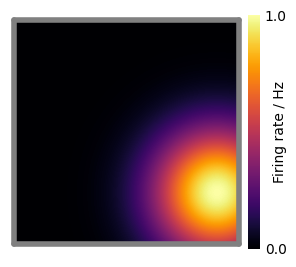

In [27]:
neuron_idx=13
print('NEURON: ', neuron_idx)
modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 'Atom', neuron_idx, xpos, ypos, title='Predicted rate maps for neuron{}'.format(neuron_idx), normalize=False)
PCs.plot_rate_map(chosen_neurons=[f'{neuron_idx}'])

In [28]:
# # OLD
# neuron_idx=13
# print('NEURON: ', neuron_idx)
# modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 'Atom', neuron_idx, xpos, ypos, title='Predicted rate maps for neuron{}'.format(neuron_idx), normalize=False)
# PCs.plot_rate_map(chosen_neurons=[f'{neuron_idx}'])

In [29]:
# source_states_curr = PCs.get_state(evaluate_at=None, pos=env_coords_small).T
# # All atoms - Plot rate map of neuron_idx
# latent_rng_seed = 0 
# zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

# activations_layer_all_atoms = [] # of length num_ckpts
# for atom_num in range(config.num_outer):
#     atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
#     activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_curr,zs, layers)
#     # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
#     activations_layer_all_atoms.append(activations_layer) 

# #TODO - select neuron_idx
# neuron_idx=40 # neuron_idx = 'all' or in range(0, activations_layer.shape[1])

# PCs.plot_rate_map(chosen_neurons=[f'{neuron_idx}'])
# print(f'Layer: {layers} - Neuron: {neuron_idx}')
# modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 'Atom', neuron_idx, xpos, ypos)

# # neuron_idx
# activations_neuron_all_atoms_allPCs = []
# for atom_idx in range(len(activations_layer_all_atoms)):
#     activations_neuron_all_atoms_allPCs.append(activations_layer_all_atoms[atom_idx][:, neuron_idx])

In [30]:
activations_layer_all_atoms_arr = np.array(activations_layer_all_atoms)

### Plot intermediate activations of ith Atom


- Plot intermediate activations as 2D maps of neurons - theta (0-360) vs Y - but model is trained with cos(theta),sin(theta),Y \
2.1. Freeze latent and see with different source states and same latent? \
2.2 Change latents slightly - tiny changes? \
2.3 see which neurons dont change when latents change a lot
- Activations over layers - entropy of neuron - average over each dim

In [31]:
# Selecting the model atom to use, and extracting its parameters , also get corresponding input
#TODO
atom_i = 0  # ith atom
num_outer = config.num_outer 
atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, num_outer)
print("Extracted params shapes for the i-th model:")
# print_params_shapes(atom_params)
print(jax.tree_map(jnp.shape, atom_params))

Extracted params shapes for the i-th model:
{'Dense_0': {'bias': (32,), 'kernel': (55, 32)}, 'Dense_1': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_2': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_3': {'bias': (50,), 'kernel': (32, 50)}}


### Dense 3 activations  - PC ratemaps 

Dense 3 activations correspond to 50 PCs outputs per source; should look like place cell ratemaps 

#### different Zs - latents

zs [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]
zs [ 0.95730704 -0.9699289  -0.1102333   0.3661903   0.1729483 ]
zs [-0.15508525  1.5718881  -0.37886548  0.17252125 -0.60508585]
NEURON:  40


/home/sruthi/Sruthi/dsm-hippocampus-main/model_viz_functions_riab.py:249: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.2, hspace=0.2)


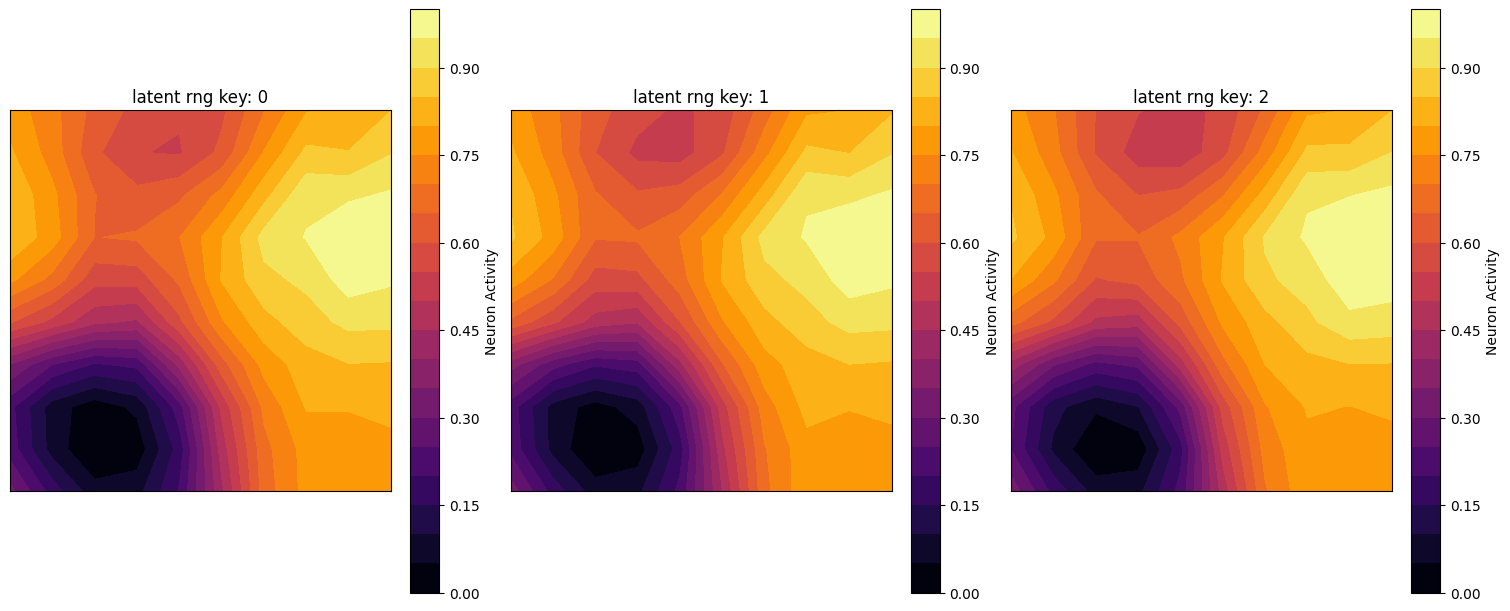

(<Figure size 250x250 with 2 Axes>, array([<Axes: >], dtype=object))

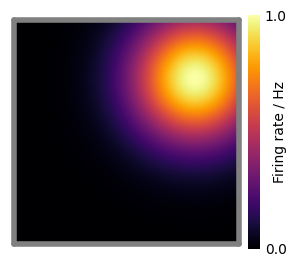

In [32]:
# - here,  test different latents
source_states_curr = PCs.get_state(evaluate_at=None, pos=env_coords_small).T

layers = ['Dense_3',]

activations_layer_randomz = []
for i in range(3):
    zs = jax.random.normal(jax.random.PRNGKey(i), (config.latent_dims,))
    # zs = np.ones((config.latent_dims)) *np.exp(i) # latent_rng not used if zs provided
    print('zs',zs)
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator,atom_params, source_states_env,zs, layers)
    activations_layer_randomz.append(activations_layer)

# Plotting all the neurons
# for i in range(len(activations_layer_randomz)):
#     neuron_idx = np.arange(activations_layer_randomz[i].shape[-1])
#     modelviz_utils.plot_neuron_activations(activations_layer_randomz[i],neuron_idx,layers,xpos,ypos)
#     # neuron_idx=0
#     # modelviz_utils.plot_neuron_activations(activations_layer_randomz[i],neuron_idx,layers,xpos,ypos)

neuron_idx=40
print('NEURON: ', neuron_idx)
modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_randomz, 'latent rng key', neuron_idx, xpos, ypos)
PCs.plot_rate_map(chosen_neurons=[f'{neuron_idx}'])
## to see scale
# modelviz_utils.plot_neuron_activations(activations_layer_randomz[0],neuron_idx,layers,xpos,ypos)


### All ATOMS - Plot rate map of neuron_idx

Layer: ['Dense_3'] - Neuron: 13


/home/sruthi/Sruthi/dsm-hippocampus-main/model_viz_functions_riab.py:249: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.2, hspace=0.2)


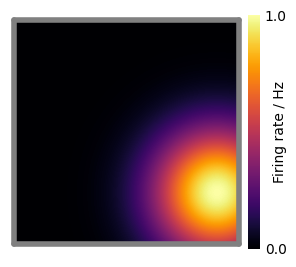

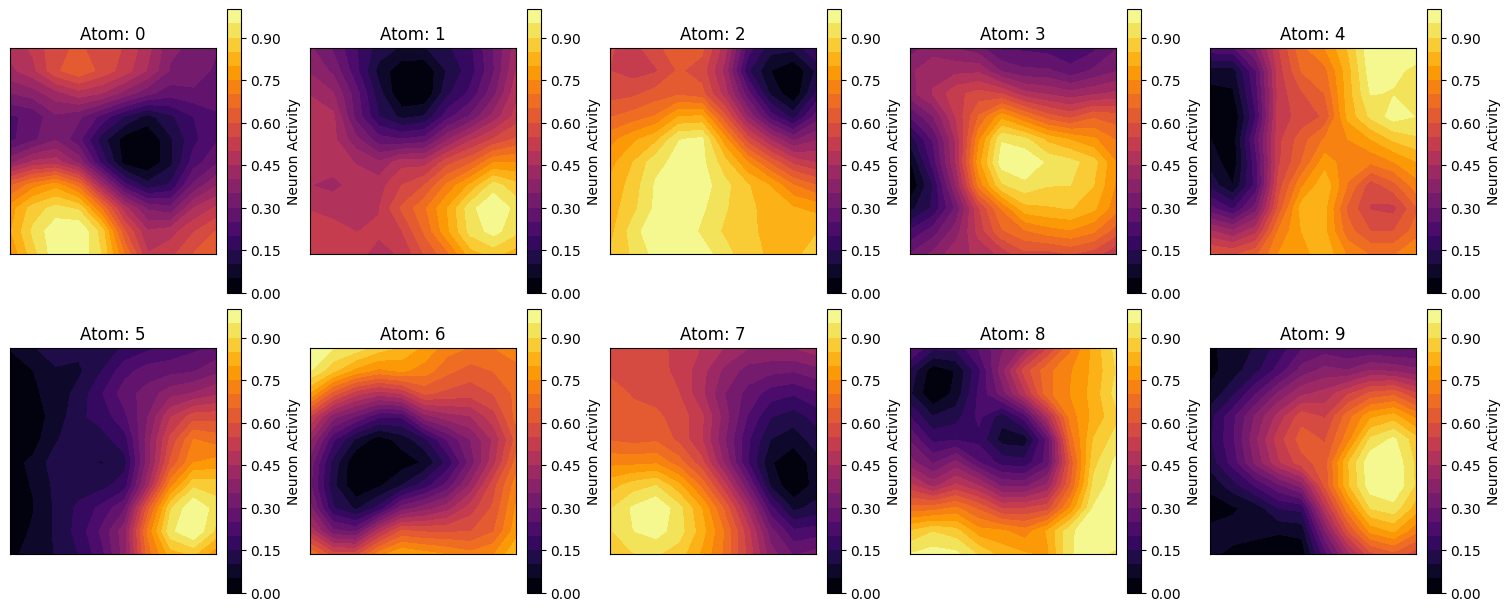

In [35]:
#TODO - select neuron_idx
neuron_idx=13 # neuron_idx = 'all' or in range(0, activations_layer.shape[1])
PCs.plot_rate_map(chosen_neurons=[f'{neuron_idx}'])
print(f'Layer: {layers} - Neuron: {neuron_idx}')
modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 'Atom', neuron_idx, xpos, ypos)

# to see scale
# modelviz_utils.plot_neuron_activations(activations_layer_all_atoms[0],neuron_idx,layers,xpos,ypos)

DOES SKEW MATCH BEHAVIOR?
- from source : do these maps correspond to movement from 
- orig pc and skewewd field 

centre of mass of both - vector between them should corrrelate to direction
- circular correlation - polar dims - not needed
- x between the vectors



### Different atom

(<Figure size 12500x250 with 100 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >], dtype=object))

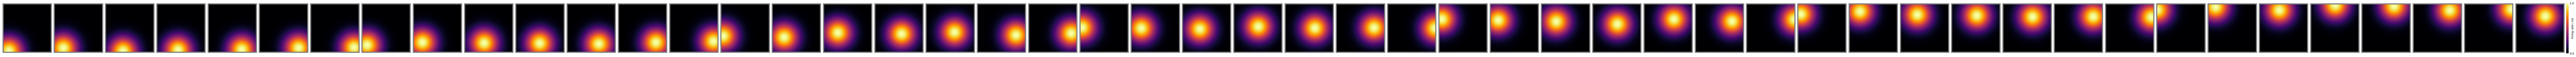

In [36]:
PCs.plot_rate_map()

activations_layer.shape: (100, 50)


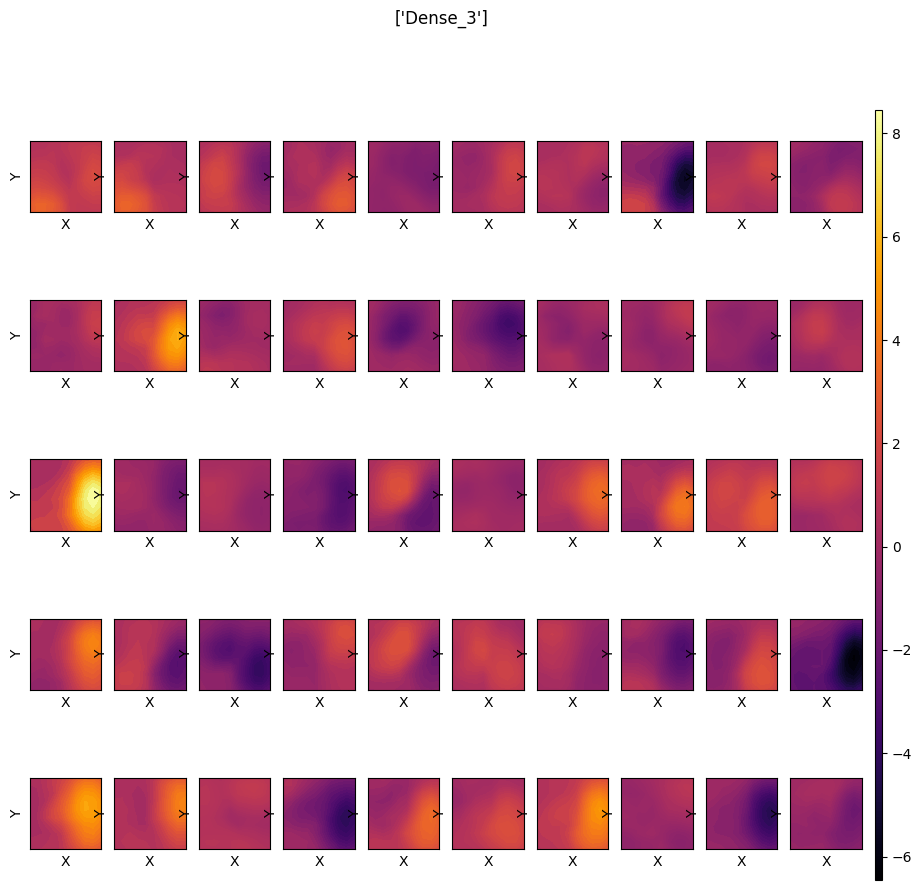

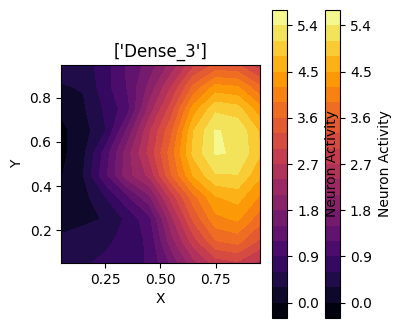

In [37]:
atom_idx = 9  # ith atom
layers = ['Dense_3',]
latent_rng_seed = 0 
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_idx, config.num_outer)
activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_env,zs, layers)
print(f'activations_layer.shape: {activations_layer.shape}')
neuron_idx = np.arange(activations_layer.shape[-1])
modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx, xpos,ypos, layers)
neuron_idx=40
modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx, xpos,ypos, layers)

In [38]:
# # OLD
# atom_idx = 9  # ith atom
# layers = ['Dense_3',]
# latent_rng_seed = 0 
# zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

# atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_idx, config.num_outer)
# activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_env,zs, layers)
# print(f'activations_layer.shape: {activations_layer.shape}')
# neuron_idx = np.arange(activations_layer.shape[-1])
# modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx, xpos,ypos, layers)
# neuron_idx=40
# modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx, xpos,ypos, layers)

### Same experiments as pendulum

### Entropy

analyze the entropy of neuron activations with respect to specific input dimensions - theta and Y  - get for each layer
- entropy over layers
- or entropy wrt source states? 


https://link.springer.com/chapter/10.1007/978-3-030-41117-6_3 - entropy reduces with layer depth? ; the neuron activation patterns become more and more stable with the depth of the fully connected layers
https://www-sciencedirect-com.libproxy.ucl.ac.uk/science/article/pii/S1570870520306958


In [39]:

env_coords_exp = Ag.Environment.discretise_environment(dx=0.05) # dx=Ag.environment.scale/10 , dx=0.01
env_coords_exp = env_coords_exp.reshape(-1, env_coords_exp.shape[-1])
# pc_full_env = PCs.get_state(evaluate_at="all").T # N of 10000 values corresponding to ag.Environment.flattened_discrete_coords # len 10000
source_states_env_exp = PCs.get_state(evaluate_at=None, pos=env_coords_exp).T

unique_xpos, indices = np.unique(env_coords_exp[:, 0], return_index=True)
xpos = unique_xpos[np.argsort(indices)]
unique_ypos, indices = np.unique(env_coords_exp[:, 1], return_index=True)
ypos = unique_ypos[np.argsort(indices)]

In [40]:
# SELECT ATOM FOR ANALYSIS

atom_i = 0  # ith atom


num_outer = config.num_outer 
atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, num_outer)
print("Extracted params shapes for the i-th model:")
# print_params_shapes(atom_params)
print(jax.tree_map(jnp.shape, atom_params))

# All intermediate layers
layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
latent_rng_seed = 0
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,))
# orig zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
atom_activations_alllayers = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, source_states_env_exp, zs, layers)

for keys,values in zip(atom_activations_alllayers.keys(), atom_activations_alllayers.values()):
    print(keys, values.shape)

# import joblib
# joblib.dump(atom_activations_alllayers, model_path+f'/activations_alllayers_atom{atom_i}_latent{latent_rng_seed}.pkl')


# print(f'activations_layer.shape: {activations_layer.shape}')
# neuron_idx = np.arange(activations_layer.shape[-1])
# modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx, xpos,ypos, layers)
# neuron_idx=40
# modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx, xpos,ypos, layers)

Extracted params shapes for the i-th model:
{'Dense_0': {'bias': (32,), 'kernel': (55, 32)}, 'Dense_1': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_2': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_3': {'bias': (50,), 'kernel': (32, 50)}}
Dense_0 (400, 32)
Dense_1 (400, 32)
Dense_2 (400, 32)
Dense_3 (400, 50)


In [41]:
from scipy.stats import entropy 

def compute_histogram_entropy(samples, num_bins=10): ## Original
    """Compute entropy from sample data using histograms."""
    # # Create histogram (density=True normalizes to get probabilities)
    # hist, bin_edges = np.histogram(samples, bins=num_bins, density=True)
    
    # # Normalize histogram to get probabilities
    # hist = hist + 1e-10  # To avoid log(0)
    # # hist_prob = hist/np.sum(hist)
    
    # # Entropy calculation using discrete entropy formula
    # hist_entropy = -np.sum(hist * np.log(hist))
    # # hist_entropy = entropy(hist_prob+ 1e-10 ) 
    # return hist_entropy

    # Compute the histogram of pixel intensities for the row
    hist, bin_edges = np.histogram(samples, bins=20, density=True)
    # Add a small value to avoid log(0) issues
    hist = hist + 1e-10
    # Compute entropy for the row
    row_entropy = entropy(hist, base=2)    
    # Return the average entropy across all rows
    return row_entropy #np.mean(row_entropy)

def compute_entropy_2dim_neuron(activations_all,layer, neuron_idx,  normalize=True,plot=False, method=1):
    activations_selected = activations_all[layer][:, neuron_idx]
    activations_2d = activations_selected.reshape(len(ypos), len(xpos))
    if plot:
        plt.imshow(activations_2d)

    if method==1:
        entropy_ys = compute_row_entropy(activations_2d) #compute_entropy_activations(distr_Y, normalize=normalize)
        entropy_xs = compute_column_entropy(activations_2d) #compute_entropy_activations(distr_xs, normalize=normalize)
    else:
        # print('method 2')    
        distr_y = np.mean(activations_2d, axis=0)       
        entropy_ys = compute_histogram_entropy(distr_y, num_bins=10) #compute_entropy_activations(distr_Y, normalize=normalize)
        distr_x = np.mean(activations_2d, axis=1)
        entropy_xs = compute_histogram_entropy(distr_x, num_bins=10) #compute_entropy_activations(distr_xs, normalize=normalize)
    return entropy_ys, entropy_xs #, entropy_all


def compute_column_entropy(image):
    """Compute entropy for each column of the image and return the average entropy."""
    image_height, image_width = image.shape  # Get the dimensions of the image
    column_entropies = []

    for x in range(image_width):
        # Get the pixel intensities for the current column
        column_pixels = image[:, x]
        
        # Compute the histogram of pixel intensities for the column
        hist, bin_edges = np.histogram(column_pixels, bins=10, density=True)
        
        # Add a small value to avoid log(0) issues
        hist = hist + 1e-10
        
        # Compute entropy for the column
        col_entropy = entropy(hist, base=2)
        
        # Store the entropy for the column
        column_entropies.append(col_entropy)
    
    # Return the average entropy across all columns
    return np.mean(column_entropies)

def compute_row_entropy(image):
    """Compute entropy for each row of the image and return the average entropy."""
    image_height, image_width = image.shape  # Get the dimensions of the image
    row_entropies = []

    for y in range(image_height):
        # Get the pixel intensities for the current row
        row_pixels = image[y, :]
        
        # Compute the histogram of pixel intensities for the row
        hist, bin_edges = np.histogram(row_pixels, bins=10,density=True)
        
        # Add a small value to avoid log(0) issues
        hist = hist + 1e-10
        
        # Compute entropy for the row
        row_entropy = entropy(hist, base=2)
        
        # Store the entropy for the row
        row_entropies.append(row_entropy)
    
    # Return the average entropy across all rows
    return np.mean(row_entropies)


Layer Dense_3 , Neuron_idx: 13, 
Entropy wrt Y 2.7859263637628806 
Entropy wrt X 2.96483714122794


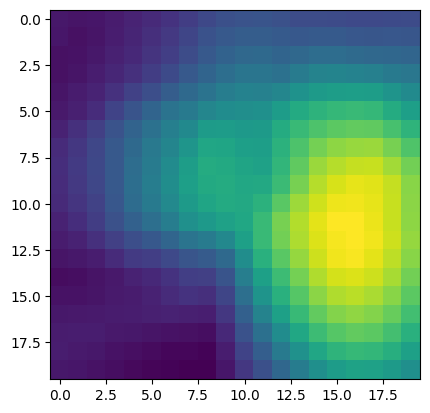

In [42]:
atom_i = 9  # ith atom

num_outer = config.num_outer 
atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, num_outer)
layers = ['Dense_3']
latent_rng_seed = 0
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,))
# orig zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
atom_activations_alllayers = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, source_states_env_exp, zs, layers)

layer = layers[0] 
neuron_idx = 13
entropy_y, entropy_x, = compute_entropy_2dim_neuron(atom_activations_alllayers, layer, neuron_idx, plot=True)
print(f'Layer {layer} , Neuron_idx: {neuron_idx}, \nEntropy wrt Y',entropy_y, '\nEntropy wrt X',entropy_x)

In [43]:
# atom_i = 9  # ith atom
# layers = ['Dense_3']
# neuron_idx = 13
# latent_rng_seed = 0
# # activations_all[layer][:, neuron_idx]
# divs = activations_2d[2:4,:]
# plt.imshow(divs)
# # entropy_ys = compute_row_entropy(divs) #compute_entropy_activations(distr_Y, normalize=normalize)
# # entropy_xs = compute_column_entropy(divs) #compute_entropy_activations(distr_xs, normalize=normalize)

# distr_y = np.mean(divs, axis=0)
# distr_x = np.mean(divs, axis=1)
# entropy_ys = compute_histogram_entropy(distr_y, num_bins=20) #compute_entropy_activations(distr_Y, normalize=normalize)
# entropy_xs = compute_histogram_entropy(distr_x, num_bins=20)
# print('y:',entropy_ys, 'x:',entropy_xs)

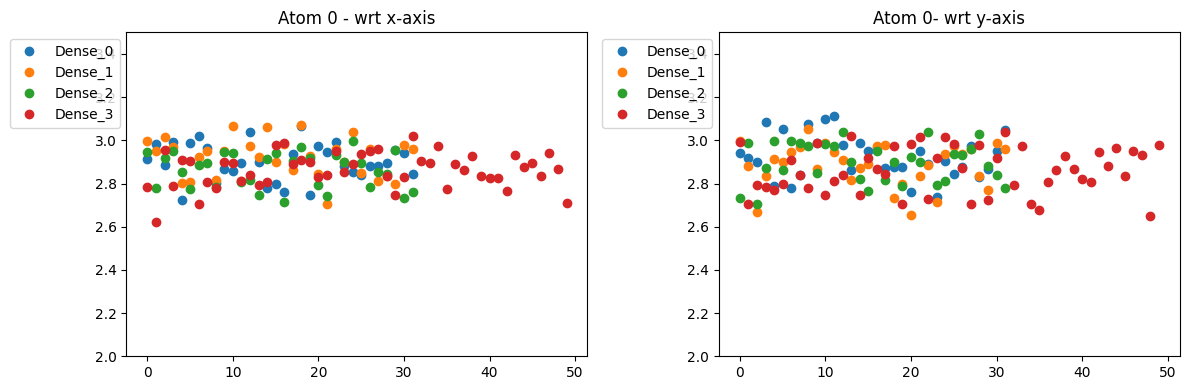

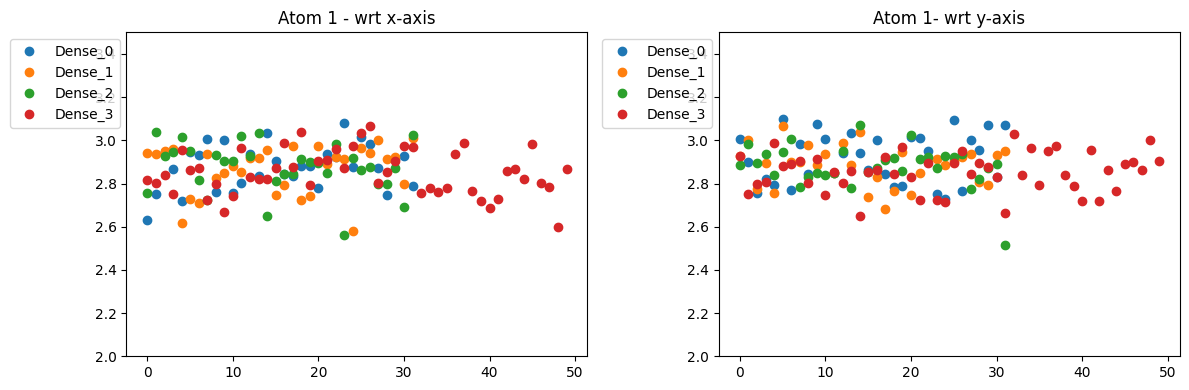

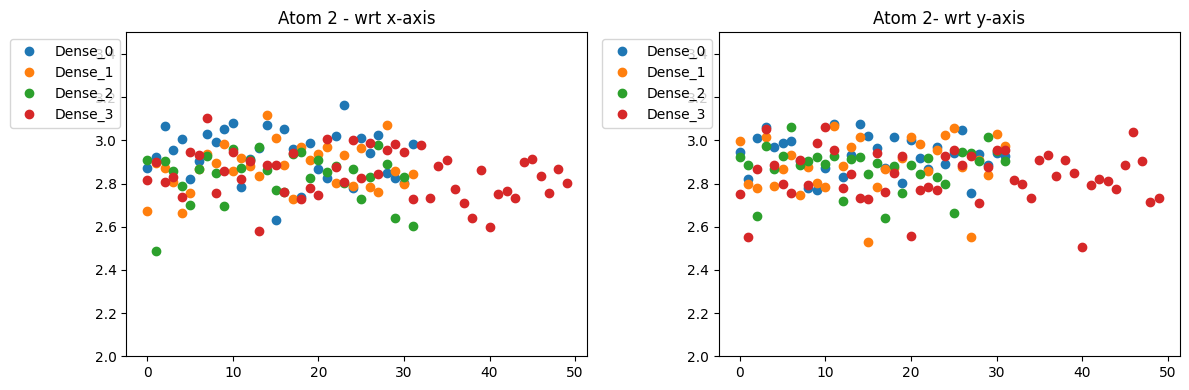

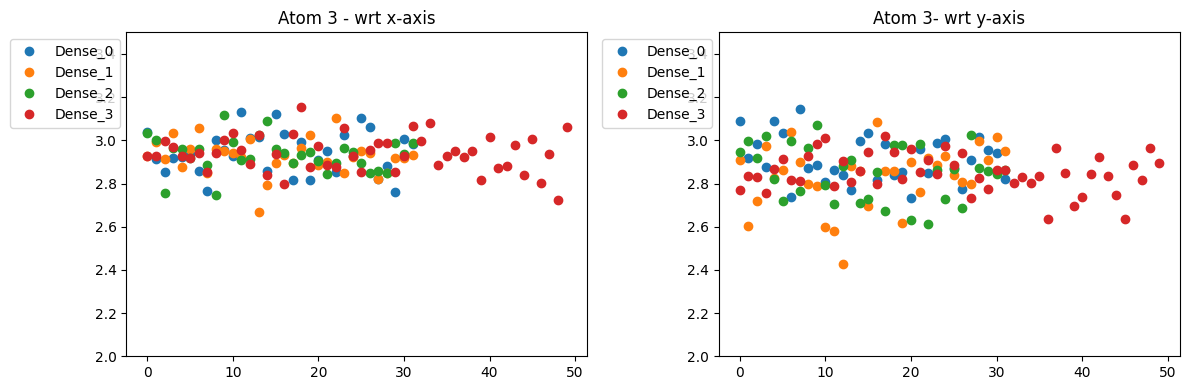

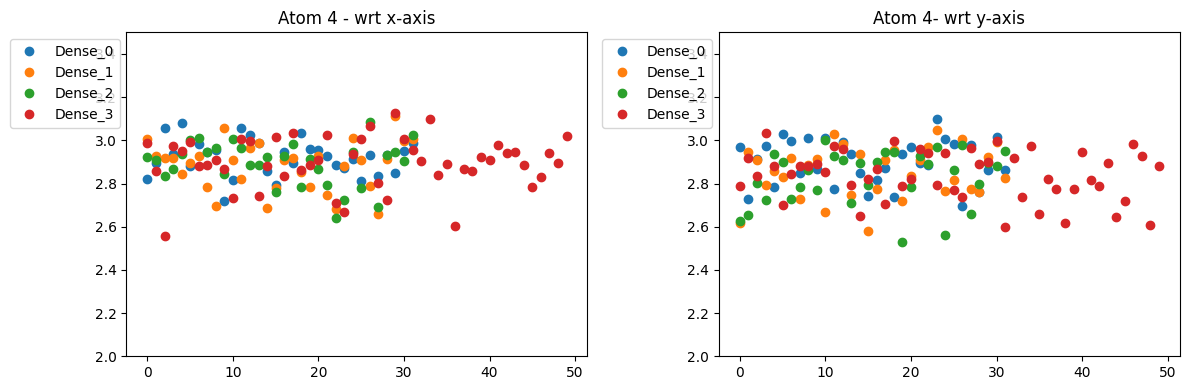

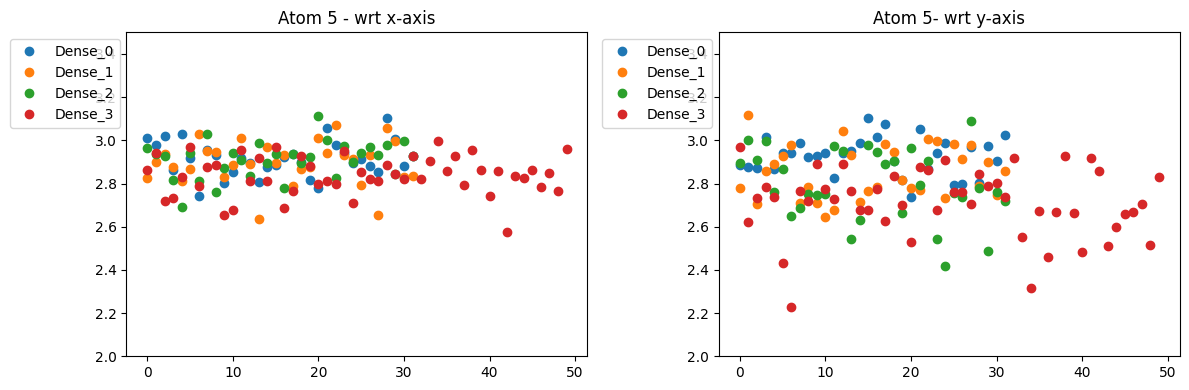

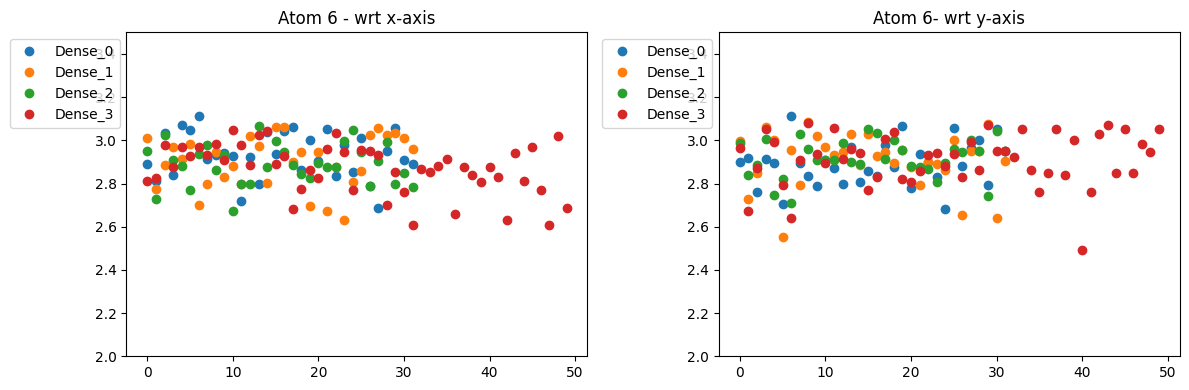

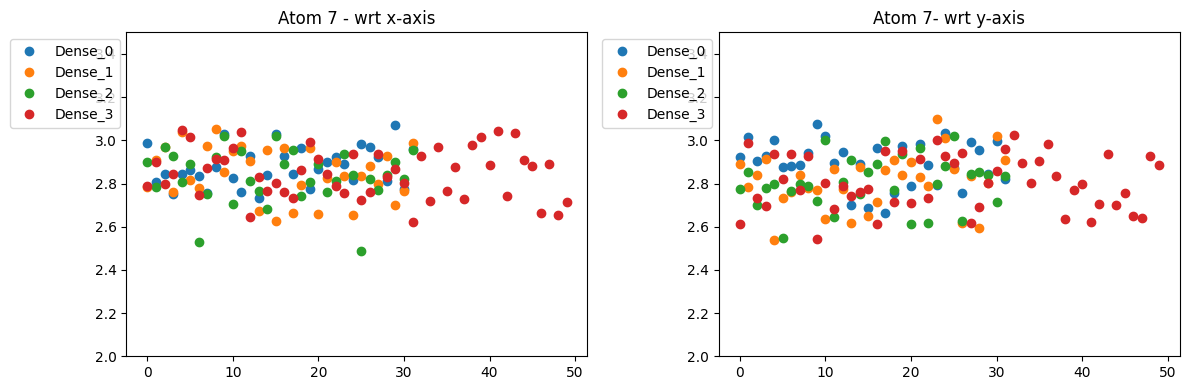

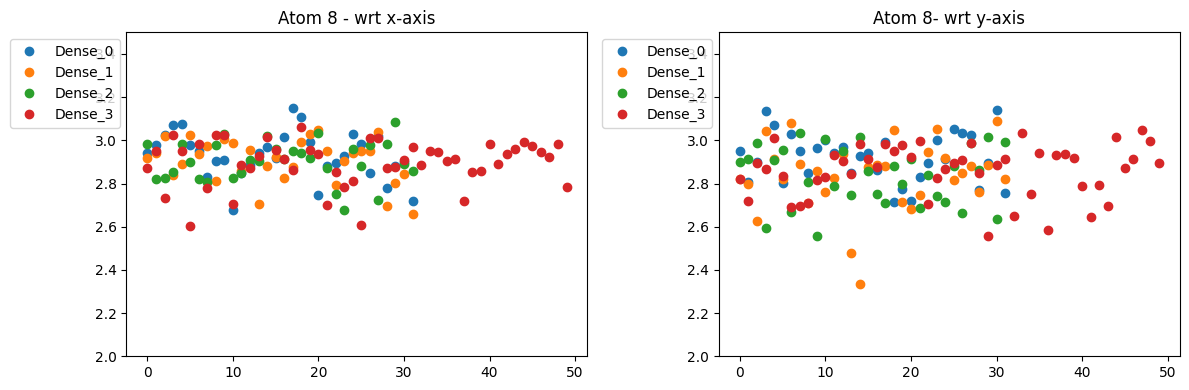

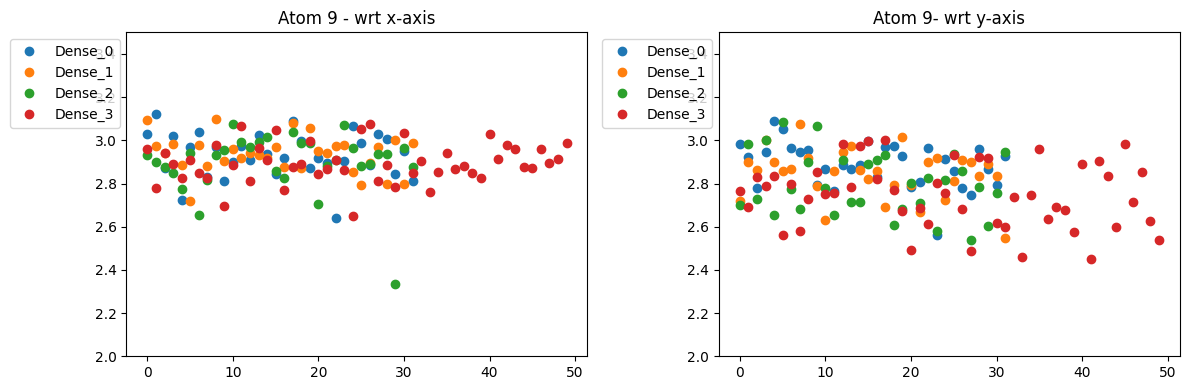

In [44]:
def choose_entropies_alllayers_1atom(atom_i, latent_rng_seed, layers,source_states_env_exp,method=1):
    atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
    zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,))
    # orig zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
    atom_activations_alllayers = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, source_states_env_exp, zs, layers)
    layer_names = list(atom_activations_alllayers.keys())
    x_entropy_all = {}
    y_entropy_all = {}
    for layer in layer_names:
        x_entropy_all[layer] = []
        y_entropy_all[layer] = []
        for neuron_idx in range(atom_activations_alllayers[layer].shape[1]):
            entropy_ys, entropy_xs = compute_entropy_2dim_neuron(atom_activations_alllayers, layer, neuron_idx,method=method)
            x_entropy_all[layer].append(entropy_xs) 
            y_entropy_all[layer].append(entropy_ys)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
    axs[0].set_title(f'Atom {atom_i} - wrt x-axis')
    for layer in layer_names:
        axs[0].plot(x_entropy_all[layer],'o',label=f'{layer}')
    axs[0].legend(bbox_to_anchor=(0, 1), loc='upper right')
    axs[1].set_title(f'Atom {atom_i}- wrt y-axis')
    for layer in layer_names:
        axs[1].plot(y_entropy_all[layer],'o',label=f'{layer}')
    axs[1].legend(bbox_to_anchor=(0, 1), loc='upper right')
    axs[0].set_ylim(2,3.5)
    axs[1].set_ylim(2,3.5)
    plt.tight_layout()
    plt.show()

latent_rng_seed = 0  # ith atom
layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
for atom_i in range(10):
    choose_entropies_alllayers_1atom(atom_i, latent_rng_seed, layers,source_states_env_exp)

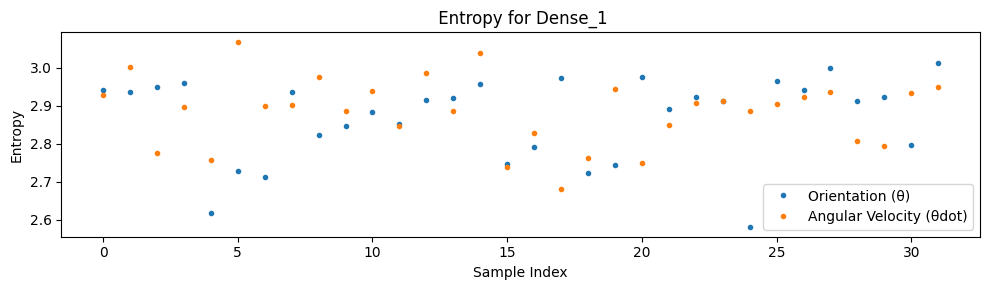

In [45]:
def plot_entropies_layers_1atom(atom_i, latent_rng_seed, layers, source_states_env):
    atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
    zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,))
    # orig zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
    atom_activations_alllayers = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, source_states_env, zs, layers)
    layer_names = list(atom_activations_alllayers.keys())
    angle_entropy_all = {}
    vel_entropy_all = {}
    for layer in layer_names:
        angle_entropy_all[layer] = []
        vel_entropy_all[layer] = []
        for neuron_idx in range(atom_activations_alllayers[layer].shape[1]):
            entropy_vel, entropy_angles = compute_entropy_2dim_neuron(atom_activations_alllayers, layer, neuron_idx)
            angle_entropy_all[layer].append(entropy_angles) 
            vel_entropy_all[layer].append(entropy_vel)

    n_layers = len(layer_names)
    fig, axs = plt.subplots(n_layers, 1, figsize=(10, n_layers * 3))
    if n_layers == 1:
        axs = np.array([axs])
    for i, layer in enumerate(layer_names):
        axs[i].plot(angle_entropy_all[layer],'.',label='Orientation (θ)')
        axs[i].plot(vel_entropy_all[layer],'.',label='Angular Velocity (θdot)')
        axs[i].set_title(f' Entropy for {layer}') # with Min-max Norm')
        axs[i].set_xlabel('Sample Index')
        axs[i].set_ylabel('Entropy')
        axs[i].legend()

    # fig.suptitle(f'ATOM {atom_i}: (ONE SAMPLE) Entropy of each layers Neuron activations wrt angles and velocity')
    plt.tight_layout()
    plt.show()

atom_i = 1  # ith atom
latent_rng_seed = 0
layers = ['Dense_1']
plot_entropies_layers_1atom(atom_i, latent_rng_seed, layers, source_states_env_exp)

### Linear decoder

1. Train decoder to map neuron activations to source states 
2. Train decoder to map neuron activations to predicted state
- Single latent, different sources split as train and test

In [46]:
source_states_env_exp.shape
num_latent_dims = config.latent_dims

In [47]:
# Training data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge   #Linear least squares with l2 regularization.
# from sklearn.gaussian_process import GaussianProcessRegressor

train_sources, test_sources = train_test_split(source_states_env_exp, test_size=0.2, random_state=42)
print(train_sources.shape)


(320, 50)


In [48]:
# get model's predictions for all sources
layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
# single_layer = 'Dense_2'
# layers = [single_layer]
zs = jax.random.normal(jax.random.PRNGKey(0), (num_latent_dims,))
train_activations_all = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, train_sources,zs, layers)
train_endstate = train_activations_all['Dense_3']
test_activations_all = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, test_sources,zs, layers)
test_endstate = test_activations_all['Dense_3']

#### Decoder from layer activations to source

R2 score for layer Dense_0: 0.9982405292059204
R2 score for layer Dense_1: 0.9906857778605658
R2 score for layer Dense_2: 0.9851098618647339
R2 score for layer Dense_3: 0.9825014972161596


Text(0.5, 1.0, 'Decoding source state - individual neuron predictions of each layer')

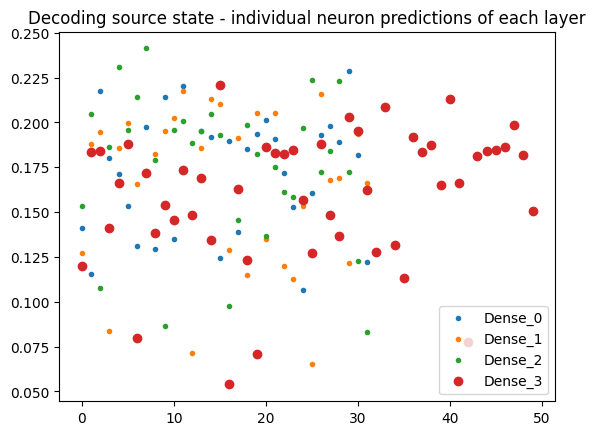

In [49]:
layer_names = list(train_activations_all.keys())
# layer_r2_scores = [] # 1- normalized least squares regression score (best 1,can be -ve)
for layer in layer_names:
    model_LR = Ridge(alpha=0.1)
    train_activations_layer = train_activations_all[layer] #[:,neuron_idx].reshape(-1,1)
    model_LR.fit(train_activations_layer, train_sources)
    test_activations_layer = test_activations_all[layer] #[:,neuron_idx].reshape(-1,1)
    # model_LR.predict(test_activations_layer)
    layer_score = model_LR.score(test_activations_layer,test_sources)
    print(f'R2 score for layer {layer}: {layer_score}')

layer_names = list(train_activations_all.keys())
for layer in layer_names:
    neuron_idx_all = np.arange(train_activations_all[layer].shape[1])
    neuron_r2_scores = []
    for neuron_idx in neuron_idx_all:
        model_LR = Ridge(alpha=0.1)
        train_activations_neuron = train_activations_all[layer][:,neuron_idx].reshape(-1,1)
        model_LR.fit(train_activations_neuron, train_sources)
        test_activations_neuron = test_activations_all[layer][:,neuron_idx].reshape(-1,1)
        neuron_r2_scores.append(model_LR.score(test_activations_neuron,test_sources))
    if layer=='Dense_3':
        plt.plot(neuron_r2_scores,'o',label=layer)
    else:
        plt.plot(neuron_r2_scores,'.',label=layer)
plt.legend()
plt.title('Decoding source state - individual neuron predictions of each layer')

In [50]:
## Train with 1 latent  and Test with different latents - decoding source state 
layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
zs = jax.random.normal(jax.random.PRNGKey(0), (num_latent_dims,))

train_activations_all = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator,atom_params, train_sources,zs, layers)
# train_activations_all[single_layer].shape
test_activations_all = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator,atom_params, test_sources,zs, layers)


zs = jax.random.normal(jax.random.PRNGKey(20), (num_latent_dims,))
train_activations_all_DIFF_LATENT = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, train_sources,zs, layers)
# train_activations_all[single_layer].shape
test_activations_all_DIFF_LATENT = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, test_sources,zs, layers)

# PREDICTING SOURCE STATE
layer_names = list(train_activations_all.keys())
# layer_r2_scores = [] # 1- normalized least squares regression score (best 1,can be -ve)
for layer in layer_names:
    model_LR = Ridge(alpha=0.1)
    model_LR.fit(train_activations_all[layer], train_sources)

    # Original latent - different source
    layer_score = round(model_LR.score(test_activations_all[layer], test_sources), 3)
    print(f'--- Original latent - different source ::: R2 score for layer {layer}: {layer_score}')
    
    # Different latent - same source as training
    layer_score = round(model_LR.score(train_activations_all_DIFF_LATENT[layer], train_sources), 3)
    print(f'Different latent - same training source ::: R2 score for layer {layer}: {layer_score}')

    # Different latent - different source
    layer_score = round(model_LR.score(test_activations_all_DIFF_LATENT[layer], test_sources), 3)
    print(f'Different latent - different source ::: R2 score for layer {layer}: {layer_score}')


--- Original latent - different source ::: R2 score for layer Dense_0: 0.998
Different latent - same training source ::: R2 score for layer Dense_0: 0.952
Different latent - different source ::: R2 score for layer Dense_0: 0.95
--- Original latent - different source ::: R2 score for layer Dense_1: 0.991
Different latent - same training source ::: R2 score for layer Dense_1: 0.968
Different latent - different source ::: R2 score for layer Dense_1: 0.961
--- Original latent - different source ::: R2 score for layer Dense_2: 0.985
Different latent - same training source ::: R2 score for layer Dense_2: 0.967
Different latent - different source ::: R2 score for layer Dense_2: 0.962
--- Original latent - different source ::: R2 score for layer Dense_3: 0.983
Different latent - same training source ::: R2 score for layer Dense_3: 0.965
Different latent - different source ::: R2 score for layer Dense_3: 0.961


#### Decoder to end

R2 score for layer Dense_0: 0.9877570271492004
R2 score for layer Dense_1: 0.9897927045822144
R2 score for layer Dense_2: 0.9947806000709534
R2 score for layer Dense_3: 0.9999500513076782


Text(0.5, 1.0, 'Decoding end state - individual neuron predictions of each layer')

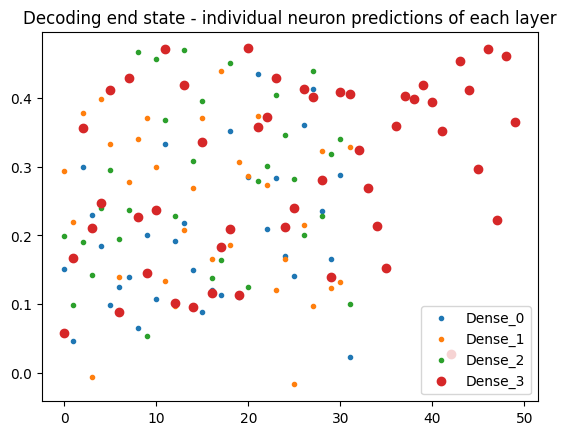

In [51]:
layer_names = list(train_activations_all.keys())
# layer_r2_scores = [] # 1- normalized least squares regression score (best 1,can be -ve)
for layer in layer_names:
    model_LR = Ridge(alpha=0.1)
    train_activations_layer = train_activations_all[layer] #[:,neuron_idx].reshape(-1,1)
    model_LR.fit(train_activations_layer, train_endstate)
    test_activations_layer = test_activations_all[layer] #[:,neuron_idx].reshape(-1,1)
    # model_LR.predict(test_activations_layer)
    layer_score = model_LR.score(test_activations_layer,test_endstate)
    print(f'R2 score for layer {layer}: {layer_score}')
    # for neuron_idx in range(train_activations_all[layer].shape[1]):

for layer in layer_names:
    neuron_idx_all = np.arange(train_activations_all[layer].shape[1])
    neuron_r2_scores = []
    for neuron_idx in neuron_idx_all:
        model_LR = Ridge(alpha=0.1)
        train_activations_neuron = train_activations_all[layer][:,neuron_idx].reshape(-1,1)
        model_LR.fit(train_activations_neuron, train_endstate)
        test_activations = test_activations_all[layer][:,neuron_idx].reshape(-1,1)
        neuron_r2_scores.append(model_LR.score(test_activations,test_endstate))
    if layer=='Dense_3':
        plt.plot(neuron_r2_scores,'o',label=layer)
    else:
        plt.plot(neuron_r2_scores,'.',label=layer)
plt.legend()
plt.title('Decoding end state - individual neuron predictions of each layer')

In [52]:
## Train with 1 latent  and Test with different latents - decoding end state

layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
zs = jax.random.normal(jax.random.PRNGKey(0), (num_latent_dims,))
train_activations_all = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, train_sources,zs, layers)
train_endstate = train_activations_all['Dense_3']
# train_activations_all[single_layer].shape
test_activations_all = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator,atom_params, test_sources,zs, layers)
test_endstate = test_activations_all['Dense_3']


zs = jax.random.normal(jax.random.PRNGKey(42), (num_latent_dims,))
train_activations_all_DIFF_LATENT = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator,atom_params, train_sources,zs, layers)
train_endstate_DIFF_LATENT = train_activations_all_DIFF_LATENT['Dense_3']
# train_activations_all[single_layer].shape
test_activations_all_DIFF_LATENT = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator,atom_params, test_sources,zs, layers)
test_endstate_DIFF_LATENT = test_activations_all_DIFF_LATENT['Dense_3']

# PREDICTING END STATE
layer_names = list(train_activations_all.keys())
# layer_r2_scores = [] # 1- normalized least squares regression score (best 1,can be -ve)
print('predicting end state')
for layer in layer_names:
    print('Layer:',layer)
    model_LR = Ridge(alpha=0.1)
    model_LR.fit(train_activations_all[layer], train_endstate)

    # Original latent - different source
    layer_score = model_LR.score(test_activations_all[layer],test_endstate)
    print(f'--- Original latent - different source (test_sources)::: R2 score for layer {layer}: {layer_score}')
    
    # Different latent - same source as training
    layer_score = model_LR.score(train_activations_all_DIFF_LATENT[layer],train_endstate_DIFF_LATENT)
    print(f'Different latent - same training source ::: R2 score for layer {layer}: {layer_score}')

    # Different latent - different source
    layer_score = model_LR.score(test_activations_all_DIFF_LATENT[layer],test_endstate_DIFF_LATENT)
    print(f'Different latent - different source (test_sources)::: R2 score for layer {layer}: {layer_score}')


predicting end state
Layer: Dense_0
--- Original latent - different source (test_sources)::: R2 score for layer Dense_0: 0.9877570271492004
Different latent - same training source ::: R2 score for layer Dense_0: 0.7933607697486877
Different latent - different source (test_sources)::: R2 score for layer Dense_0: 0.7536770701408386
Layer: Dense_1
--- Original latent - different source (test_sources)::: R2 score for layer Dense_1: 0.9897927045822144
Different latent - same training source ::: R2 score for layer Dense_1: 0.9793118834495544
Different latent - different source (test_sources)::: R2 score for layer Dense_1: 0.9756268858909607
Layer: Dense_2
--- Original latent - different source (test_sources)::: R2 score for layer Dense_2: 0.9947806000709534
Different latent - same training source ::: R2 score for layer Dense_2: 0.9905727505683899
Different latent - different source (test_sources)::: R2 score for layer Dense_2: 0.9881051778793335
Layer: Dense_3
--- Original latent - different

In [53]:
# Gettting score with WRONG latent for predictions - implying latent isn't very important
layer_score = model_LR.score(test_activations_all_DIFF_LATENT[layer],test_endstate)
print(f'Wrong latent - different source (test_sources)::: R2 score for layer {layer}: {layer_score}')
layer_score = model_LR.score(train_activations_all_DIFF_LATENT[layer],train_endstate)
print(f'Wrong latent - different source (train_sources)::: R2 score for layer {layer}: {layer_score}')

Wrong latent - different source (test_sources)::: R2 score for layer Dense_3: 0.9242531657218933
Wrong latent - different source (train_sources)::: R2 score for layer Dense_3: 0.9400351047515869


### tsne umap

In [54]:
env_coords_exp = Ag.Environment.discretise_environment(dx=0.05) # dx=Ag.environment.scale/10 , dx=0.01
env_coords_exp = env_coords_exp.reshape(-1, env_coords_exp.shape[-1])
source_states_env_exp = PCs.get_state(evaluate_at=None, pos=env_coords_exp).T

xs_all = env_coords_exp[:,0]
ys_all = env_coords_exp[:,1]

In [55]:
atom_i = 7
latent_rng_seed = 0
layers_all = ['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3'] 
atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (num_latent_dims,))
# orig zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
atom_activations_alllayers = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, 
                                                                                                     source_states_env_exp, zs, layers_all)

In [56]:
# !python -m pip install umap-learn
from sklearn.manifold import TSNE
# from umap import UMAP
import umap.umap_ as umap

/home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
# 2 component t-SNE
layer_names = list(atom_activations_alllayers.keys())
n_layers = len(layer_names)
tsne_2comp = {}
for layer in layer_names:
    train_activations_layer = atom_activations_alllayers[layer] #[:,neuron_idx].reshape(-1,1)
    tsne = TSNE(n_components=2, random_state=0)
    projections = tsne.fit_transform(train_activations_layer)
    tsne_2comp[layer] = projections

/tmp/ipykernel_144384/3254284312.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reversed_map = plt.cm.get_cmap('viridis').reversed()


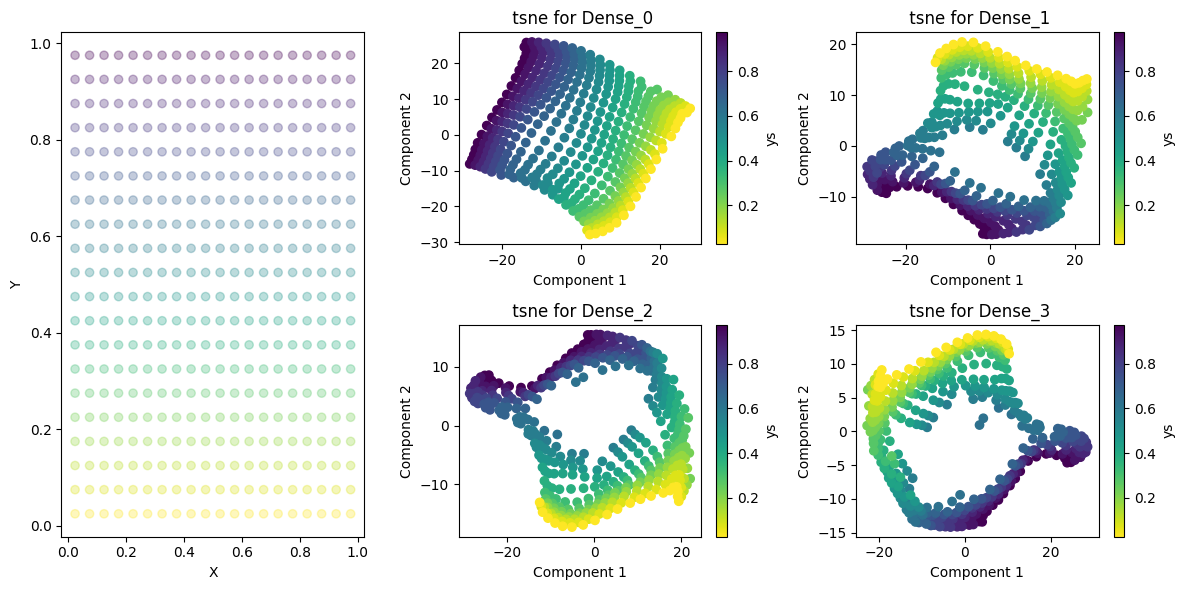

In [58]:
from matplotlib import gridspec
reversed_map = plt.cm.get_cmap('viridis').reversed() 

fig = plt.figure(figsize=(12,6))  # Adjust the figure size
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1])  # 2 rows, 3 columns

# Add your centered plot to the left column
ax = plt.subplot(gs[:, 0])  # This plot spans all rows and the first column
# Add your plot code here
ax.scatter(xs_all, ys_all, alpha=0.3, c=ys_all, cmap=reversed_map)  # Use the numbers as colors
ax.set_xlabel('X')
ax.set_ylabel('Y')
# fig.suptitle('Source states - colored by velocities')

for i, layer in enumerate(layer_names):
    ax = plt.subplot(gs[i//2, i%2+1])  # Adjust the indices to leave the first column empty
    scatter = ax.scatter(tsne_2comp[layer][:, 0],tsne_2comp[layer][:, 1],c=ys_all, cmap=reversed_map)
    ax.set_title(f' tsne for {layer}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    fig.colorbar(scatter, ax=ax, label='ys')

plt.tight_layout()
plt.show()

/tmp/ipykernel_144384/178146650.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reversed_map = plt.cm.get_cmap('viridis').reversed()


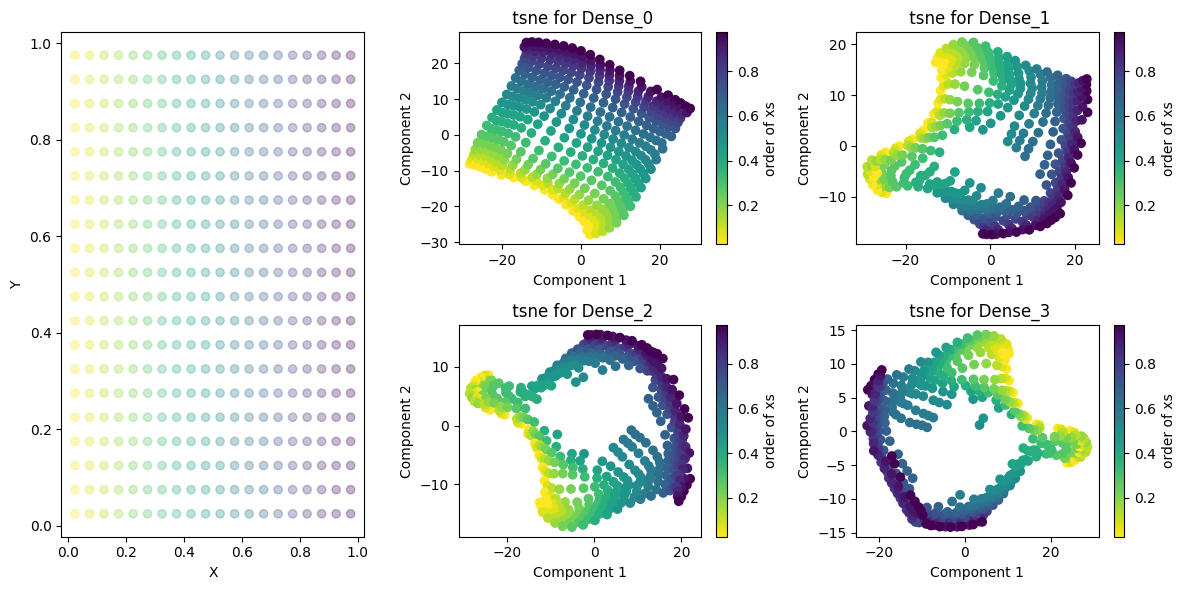

In [59]:
from matplotlib import gridspec
reversed_map = plt.cm.get_cmap('viridis').reversed() 

fig = plt.figure(figsize=(12,6))  # Adjust the figure size
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1])  # 2 rows, 3 columns

# Add your centered plot to the left column
ax = plt.subplot(gs[:, 0])  # This plot spans all rows and the first column
# Add your plot code here
ax.scatter(xs_all, ys_all, alpha=0.3, c=xs_all, cmap=reversed_map)  # Use the numbers as colors
ax.set_xlabel('X')
ax.set_ylabel('Y')
# fig.suptitle('Source states - colored by velocities')

for i, layer in enumerate(layer_names):
    ax = plt.subplot(gs[i//2, i%2+1])  # Adjust the indices to leave the first column empty
    scatter = ax.scatter(tsne_2comp[layer][:, 0],tsne_2comp[layer][:, 1],c=xs_all, cmap=reversed_map)
    ax.set_title(f' tsne for {layer}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    fig.colorbar(scatter, ax=ax, label='order of xs')

plt.tight_layout()
plt.show()

/home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed f

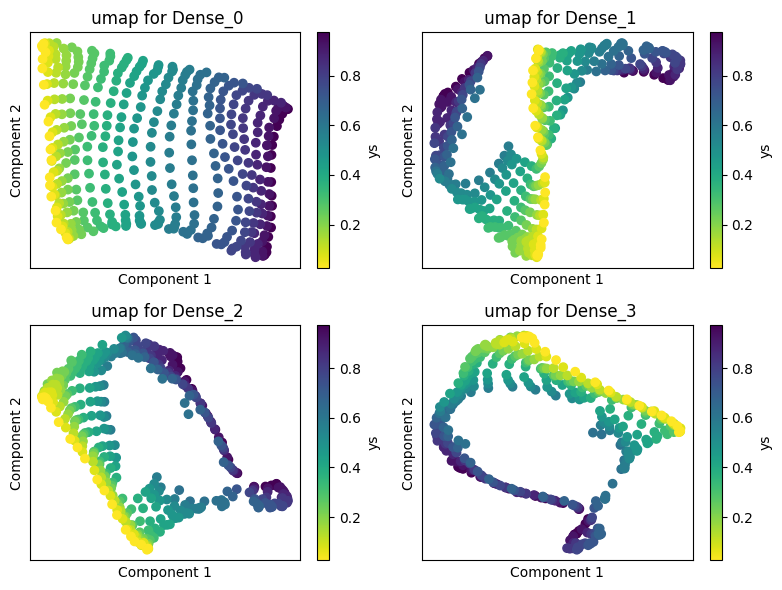

In [60]:
# UMAP 2D 
layer_names = list(atom_activations_alllayers.keys())
n_layers = len(layer_names)
umap_all2d = {}
for layer in layer_names:
    umap_2d = umap.UMAP(n_components=2, init='random', random_state=0)
    train_activations_layer = atom_activations_alllayers[layer] #[:,neuron_idx].reshape(-1,1)
    umap_all2d[layer] = umap_2d.fit_transform(train_activations_layer)

fig = plt.figure(figsize=(8,6)) 
for i, layer in enumerate(layer_names):
    ax = fig.add_subplot(2, 2, i+1) 
    scatter = ax.scatter(umap_all2d[layer][:, 0],umap_all2d[layer][:, 1], c = ys_all, cmap = reversed_map)
    ax.set_title(f' umap for {layer}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_xticks([])  # Remove xticks
    ax.set_yticks([])
    # axs[i].legend()
    fig.colorbar(scatter, ax=ax, label='ys')
plt.tight_layout()
plt.show()

### Other Dense layers

#### Dense 0,1,2

In [61]:
atom_i

7

zs [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]


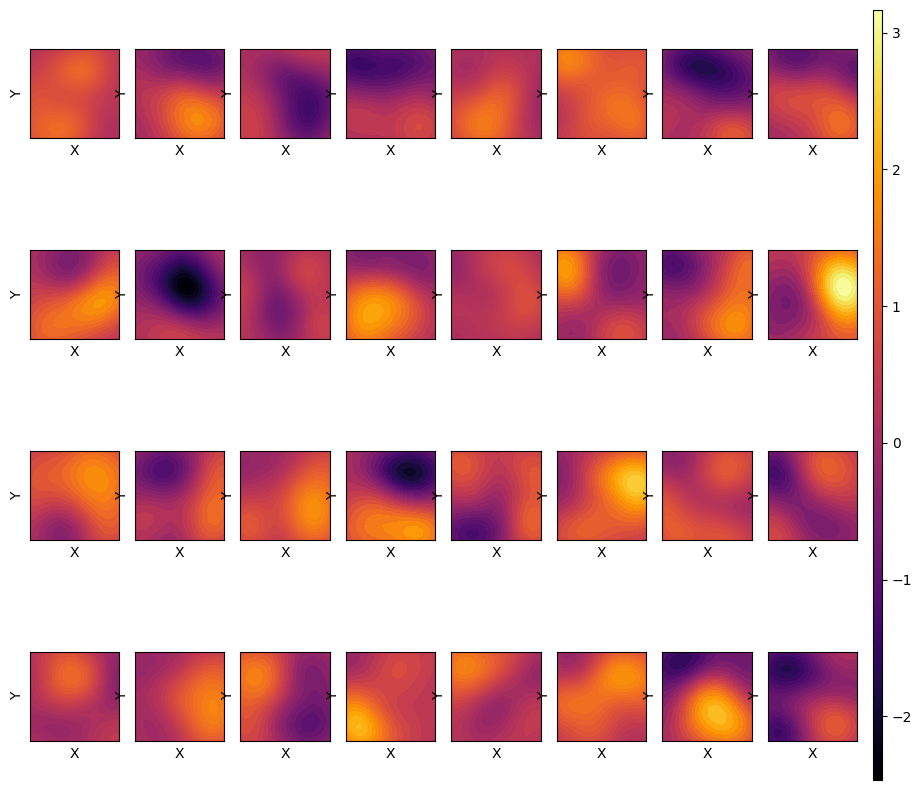

In [62]:
layers = ['Dense_0',]

activations_layer_randomz = []
for i in range(1):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (config.latent_dims,))
    print('zs',zs)
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator,atom_params, source_states_env_exp,zs, layers)
    activations_layer_randomz.append(activations_layer)

activations_layer = activations_layer_randomz[0]
neuron_idx = np.arange(0, min(50,activations_layer.shape[1]))
modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,xpos,ypos)

zs [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]


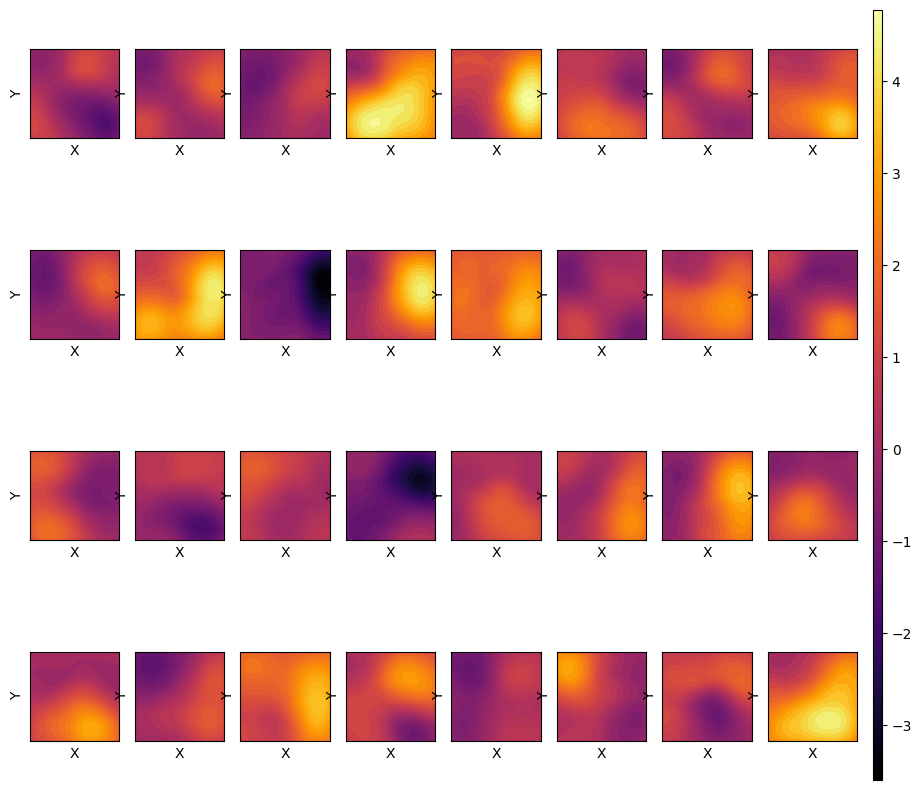

In [63]:
layers = ['Dense_1',]

activations_layer_randomz = []
for i in range(1):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (config.latent_dims,))
    print('zs',zs)
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator,atom_params, source_states_env_exp,zs, layers)
    activations_layer_randomz.append(activations_layer)

activations_layer = activations_layer_randomz[0]
neuron_idx = np.arange(0, min(50,activations_layer.shape[1]))
modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,xpos,ypos)

zs [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]
(400, 32)


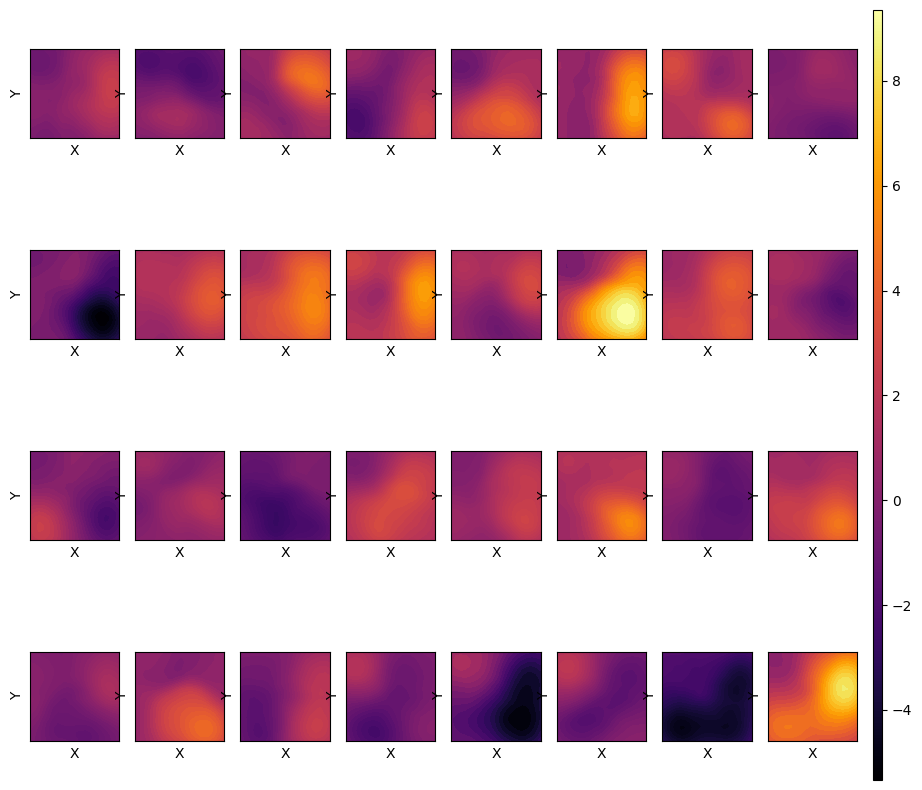

In [64]:
layers = ['Dense_2',]

activations_layer_randomz = []
for i in range(1):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (config.latent_dims,))
    print('zs',zs)
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_env_exp,zs, layers)
    activations_layer_randomz.append(activations_layer)

    print(activations_layer.shape)
    neuron_idx = np.arange(0, min(50,activations_layer.shape[1]))
    modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx, xpos,ypos)


In [65]:
# atom_idx = 9  # ith atom
# layers = ['Dense_3',]
# latent_rng_seed = 0 
# zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

# atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_idx, config.num_outer)
# activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_env,zs, layers)
# print(f'activations_layer.shape: {activations_layer.shape}')
# neuron_idx = np.arange(activations_layer.shape[-1])
# modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx, xpos,ypos, layers)
# neuron_idx=40
# modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx, xpos,ypos, layers)

zs [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]
(400, 50)


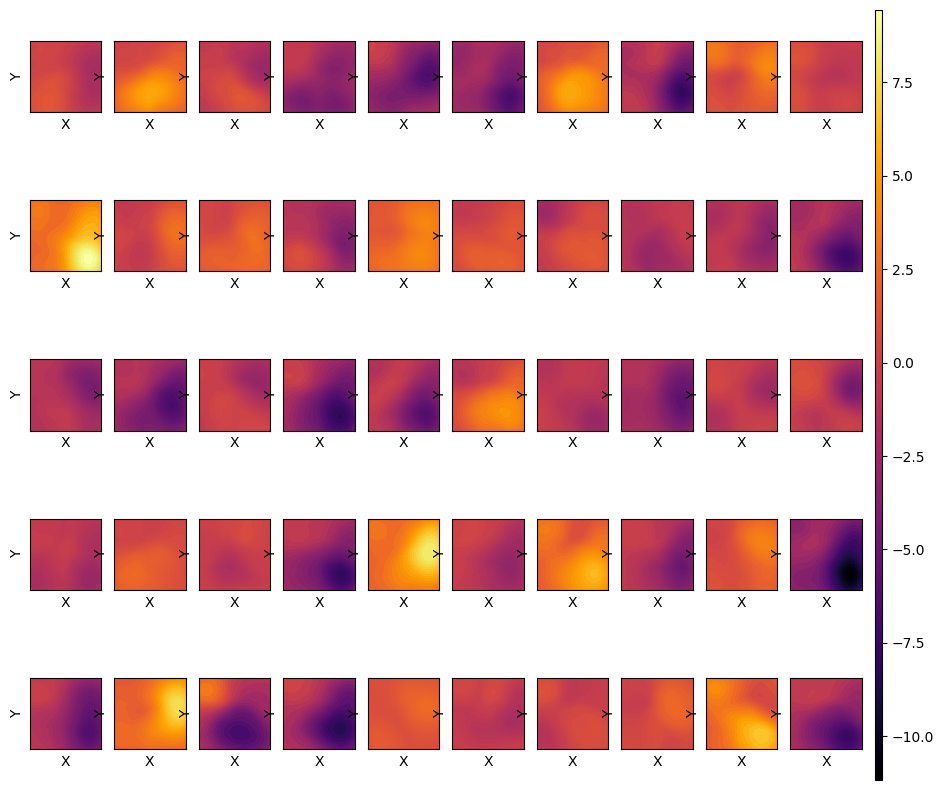

In [66]:
layers = ['Dense_3',]

activations_layer_randomz = []
for i in range(1):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (config.latent_dims,))
    print('zs',zs)
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_env_exp,zs, layers)
    activations_layer_randomz.append(activations_layer)

    print(activations_layer.shape)
    neuron_idx = np.arange(0, min(50,activations_layer.shape[1]))
    modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx, xpos,ypos)


In [67]:
### All intermediates

# #TODO - select layer
# layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
# rng = jax.random.PRNGKey(0)
# zs = jax.random.normal(rng, (num_latent_dims,))
# # zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
# activations_alllayers = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, source_states_env, zs, layers)
# # print(activations_alllayers['Dense_0'] )

# joblib.dump(activations_alllayers, model_path+f'/activations_alllayers_latent_atom{atom_i}.pkl')
# # activations_alllayers = joblib.load('activations_alllayers_latent0.pkl')